In [1]:
#! git clone https://github.com/LintaoPeng/U-shape_Transformer_for_Underwater_Image_Enhancement

In [2]:
#!pip install -r /content/requirements.txt

In [3]:
#from google.colab import files

In [4]:
#from utility.ptcolor import rgb2lab
#from utility.Qnt import quantAB,quantL
import torch
from torch.nn import functional
import torch.nn as nn


class lab_Loss(nn.Module):
    def __init__(self, alpha=1,weight=1,levels=7,vmin=-80,vmax=80):
        super(lab_Loss, self).__init__()
        self.alpha=alpha
        self.weight=weight
        self.levels=levels
        self.vmin=vmin
        self.vmax=vmax

    def Hist_2_Dist_L(self,img, tab,alpha):
        img_dist=((img.unsqueeze(1)-tab)**2)
        p=functional.softmax(-alpha*img_dist,dim=1)
        return p

    def Hist_2_Dist_AB(self,img,tab,alpha):
        img_dist=((img.unsqueeze(1)-tab)**2).sum(2)
        p = torch.nn.functional.softmax(-alpha*img_dist, dim=1)
        return p

    def loss_ab(self,img,gt,alpha,tab,levels):
        p= self.Hist_2_Dist_AB(img, tab,alpha).cuda()
        q= self.Hist_2_Dist_AB(gt,tab,alpha).cuda()
        p = torch.clamp(p, 0.001, 0.999)
        loss = -(q*torch.log(p)).sum([1,2,3]).mean()
        return loss




    def forward(self,img,gt):
	    tab=quantAB(self.levels,self.vmin,self.vmax).cuda()
	    lab_img=torch.clamp(rgb2lab(img),self.vmin,self.vmax)
	    lab_gt=torch.clamp(rgb2lab(gt),self.vmin,self.vmax)

	    loss_l=torch.abs(lab_img[:,0,:,:]-lab_gt[:,0,:,:]).mean()
	    loss_AB=self.loss_ab(lab_img[:,1:,:,:],lab_gt[:,1:,:,:],self.alpha,tab,self.levels)
	    loss=loss_l+self.weight*loss_AB
	    #return (loss,loss_l,loss_AB)
	    return loss

In [5]:
import torch
#from utilities import ptcolor as ptcolor
import torch.nn as nn

class lch_Loss(nn.Module):
    def __init__(self, weightC=1,weightH=1,levels=4,eps=0.01,weight=None):
        super(lch_Loss, self).__init__()
        self.weightC=weightC
        self.weightH=weightH
        self.levels=levels
        self.eps=eps
        self.weight=weight


    def hue_to_distribution(self,h, levels, eps=0.0):
        h = h * (levels / 360.0)
        a = torch.arange(levels).float().to(h.device)
        a = a.view(1, levels, 1, 1)
        h=h.unsqueeze(1)
        p = torch.relu(1 - torch.abs(h - a))
        p = p + (a == 0.0).float() * p[:, -1:, :, :]
        p = (p + torch.ones_like(p) * eps) / (1.0 + levels * eps)
        return p



    def forward(self,img,gt):
        img_lch= ptcolor.rgb2lch(img)
        gt_lch= ptcolor.rgb2lch(gt)
        loss_L=torch.mean(torch.abs(img_lch[:,0,:,:]-gt_lch[:,0,:,:]))
        loss_C=torch.mean(torch.abs(img_lch[:,1,:,:]-gt_lch[:,1,:,:]))
        img_H_Dist=torch.clamp(self.hue_to_distribution(img_lch[:,2,:,:],self.levels,self.eps),0.001, 0.999)
        gt_H_Dist =torch.clamp(self.hue_to_distribution(gt_lch[:, 2, :, :], self.levels),0.001, 0.999)
        if self.weight is None:
            loss_H = torch.mean(-torch.mul(gt_H_Dist, torch.log(img_H_Dist)))
        else:
            loss_H = -(gt_lch[:,1,:,:]*(gt_H_Dist*torch.log(img_H_Dist)).sum(1,keepdim=True)).mean()
        loss=loss_L+self.weightC*loss_C+self.weightH*loss_H
        #return(loss,loss_L,loss_C,loss_H)
        return loss

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import copy
import logging
import math
import torch
import torch.nn as nn
import numpy as np
from torch.nn import Dropout, Softmax, Conv2d, LayerNorm
from torch.nn.modules.utils import _pair


#KV_size = 480
#transformer.num_heads  = 4
#transformer.num_layers = 4
#expand_ratio           = 4



#线性编码
class Channel_Embeddings(nn.Module):
    """Construct the embeddings from patch, position embeddings.
    """
    def __init__(self, patchsize, img_size, in_channels):
        super().__init__()
        img_size = _pair(img_size)
        patch_size = _pair(patchsize)
        n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])

        self.patch_embeddings = Conv2d(in_channels=in_channels,
                                       out_channels=in_channels,
                                       kernel_size=patch_size,
                                       stride=patch_size)
        self.position_embeddings = nn.Parameter(torch.zeros(1, n_patches, in_channels))
        self.dropout = Dropout(0.1)

    def forward(self, x):
        if x is None:
            return None
        x = self.patch_embeddings(x)  # (B, hidden，n_patches^(1/2), n_patches^(1/2))
        x = x.flatten(2)
        x = x.transpose(-1, -2)  # (B, n_patches, hidden)
        embeddings = x + self.position_embeddings
        embeddings = self.dropout(embeddings)
        return embeddings


#特征重组
class Reconstruct(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, scale_factor):
        super(Reconstruct, self).__init__()
        if kernel_size == 3:
            padding = 1
        else:
            padding = 0
        self.conv = nn.Conv2d(in_channels, out_channels,kernel_size=kernel_size, padding=padding)
        self.norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU(inplace=True)
        self.scale_factor = scale_factor

    def forward(self, x):
        if x is None:
            return None

        # reshape from (B, n_patch, hidden) to (B, h, w, hidden)
        B, n_patch, hidden = x.size()  
        h, w = int(np.sqrt(n_patch)), int(np.sqrt(n_patch))
        x = x.permute(0, 2, 1)
        x = x.contiguous().view(B, hidden, h, w)
        x = nn.Upsample(scale_factor=self.scale_factor)(x)

        out = self.conv(x)
        out = self.norm(out)
        out = self.activation(out)
        return out

class Attention_org(nn.Module):
    def __init__(self, vis,channel_num, KV_size=480, num_heads=4):
        super(Attention_org, self).__init__()
        self.vis = vis
        self.KV_size = KV_size
        self.channel_num = channel_num
        self.num_attention_heads = num_heads

        self.query1 = nn.ModuleList()
        self.query2 = nn.ModuleList()
        self.query3 = nn.ModuleList()
        self.query4 = nn.ModuleList()
        self.key = nn.ModuleList()
        self.value = nn.ModuleList()

        for _ in range(num_heads):
            query1 = nn.Linear(channel_num[0], channel_num[0], bias=False)
            query2 = nn.Linear(channel_num[1], channel_num[1], bias=False)
            query3 = nn.Linear(channel_num[2], channel_num[2], bias=False)
            query4 = nn.Linear(channel_num[3], channel_num[3], bias=False)
            key = nn.Linear( self.KV_size,  self.KV_size, bias=False)
            value = nn.Linear(self.KV_size,  self.KV_size, bias=False)
            #把所有的值都重新复制一遍，deepcopy为深复制，完全脱离原来的值，即将被复制对象完全再复制一遍作为独立的新个体单独存在
            self.query1.append(copy.deepcopy(query1))
            self.query2.append(copy.deepcopy(query2))
            self.query3.append(copy.deepcopy(query3))
            self.query4.append(copy.deepcopy(query4))
            self.key.append(copy.deepcopy(key))
            self.value.append(copy.deepcopy(value))
        self.psi = nn.InstanceNorm2d(self.num_attention_heads)
        self.softmax = Softmax(dim=3)
        self.out1 = nn.Linear(channel_num[0], channel_num[0], bias=False)
        self.out2 = nn.Linear(channel_num[1], channel_num[1], bias=False)
        self.out3 = nn.Linear(channel_num[2], channel_num[2], bias=False)
        self.out4 = nn.Linear(channel_num[3], channel_num[3], bias=False)
        self.attn_dropout = Dropout(0.1)
        self.proj_dropout = Dropout(0.1)



    def forward(self, emb1,emb2,emb3,emb4, emb_all):
        multi_head_Q1_list = []
        multi_head_Q2_list = []
        multi_head_Q3_list = []
        multi_head_Q4_list = []
        multi_head_K_list = []
        multi_head_V_list = []
        if emb1 is not None:
            for query1 in self.query1:
                Q1 = query1(emb1)
                multi_head_Q1_list.append(Q1)
        if emb2 is not None:
            for query2 in self.query2:
                Q2 = query2(emb2)
                multi_head_Q2_list.append(Q2)
        if emb3 is not None:
            for query3 in self.query3:
                Q3 = query3(emb3)
                multi_head_Q3_list.append(Q3)
        if emb4 is not None:
            for query4 in self.query4:
                Q4 = query4(emb4)
                multi_head_Q4_list.append(Q4)
        for key in self.key:
            K = key(emb_all)
            multi_head_K_list.append(K)
        for value in self.value:
            V = value(emb_all)
            multi_head_V_list.append(V)
        # print(len(multi_head_Q4_list))

        multi_head_Q1 = torch.stack(multi_head_Q1_list, dim=1) if emb1 is not None else None
        multi_head_Q2 = torch.stack(multi_head_Q2_list, dim=1) if emb2 is not None else None
        multi_head_Q3 = torch.stack(multi_head_Q3_list, dim=1) if emb3 is not None else None
        multi_head_Q4 = torch.stack(multi_head_Q4_list, dim=1) if emb4 is not None else None
        multi_head_K = torch.stack(multi_head_K_list, dim=1)
        multi_head_V = torch.stack(multi_head_V_list, dim=1)

        multi_head_Q1 = multi_head_Q1.transpose(-1, -2) if emb1 is not None else None
        multi_head_Q2 = multi_head_Q2.transpose(-1, -2) if emb2 is not None else None
        multi_head_Q3 = multi_head_Q3.transpose(-1, -2) if emb3 is not None else None
        multi_head_Q4 = multi_head_Q4.transpose(-1, -2) if emb4 is not None else None

        attention_scores1 = torch.matmul(multi_head_Q1, multi_head_K) if emb1 is not None else None
        attention_scores2 = torch.matmul(multi_head_Q2, multi_head_K) if emb2 is not None else None
        attention_scores3 = torch.matmul(multi_head_Q3, multi_head_K) if emb3 is not None else None
        attention_scores4 = torch.matmul(multi_head_Q4, multi_head_K) if emb4 is not None else None

        attention_scores1 = attention_scores1 / math.sqrt(self.KV_size) if emb1 is not None else None
        attention_scores2 = attention_scores2 / math.sqrt(self.KV_size) if emb2 is not None else None
        attention_scores3 = attention_scores3 / math.sqrt(self.KV_size) if emb3 is not None else None
        attention_scores4 = attention_scores4 / math.sqrt(self.KV_size) if emb4 is not None else None

        attention_probs1 = self.softmax(self.psi(attention_scores1)) if emb1 is not None else None
        attention_probs2 = self.softmax(self.psi(attention_scores2)) if emb2 is not None else None
        attention_probs3 = self.softmax(self.psi(attention_scores3)) if emb3 is not None else None
        attention_probs4 = self.softmax(self.psi(attention_scores4)) if emb4 is not None else None
        # print(attention_probs4.size())

        if self.vis:
            weights =  []
            weights.append(attention_probs1.mean(1))
            weights.append(attention_probs2.mean(1))
            weights.append(attention_probs3.mean(1))
            weights.append(attention_probs4.mean(1))
        else: weights=None

        attention_probs1 = self.attn_dropout(attention_probs1) if emb1 is not None else None
        attention_probs2 = self.attn_dropout(attention_probs2) if emb2 is not None else None
        attention_probs3 = self.attn_dropout(attention_probs3) if emb3 is not None else None
        attention_probs4 = self.attn_dropout(attention_probs4) if emb4 is not None else None

        multi_head_V = multi_head_V.transpose(-1, -2)
        context_layer1 = torch.matmul(attention_probs1, multi_head_V) if emb1 is not None else None
        context_layer2 = torch.matmul(attention_probs2, multi_head_V) if emb2 is not None else None
        context_layer3 = torch.matmul(attention_probs3, multi_head_V) if emb3 is not None else None
        context_layer4 = torch.matmul(attention_probs4, multi_head_V) if emb4 is not None else None

        context_layer1 = context_layer1.permute(0, 3, 2, 1).contiguous() if emb1 is not None else None
        context_layer2 = context_layer2.permute(0, 3, 2, 1).contiguous() if emb2 is not None else None
        context_layer3 = context_layer3.permute(0, 3, 2, 1).contiguous() if emb3 is not None else None
        context_layer4 = context_layer4.permute(0, 3, 2, 1).contiguous() if emb4 is not None else None
        context_layer1 = context_layer1.mean(dim=3) if emb1 is not None else None
        context_layer2 = context_layer2.mean(dim=3) if emb2 is not None else None
        context_layer3 = context_layer3.mean(dim=3) if emb3 is not None else None
        context_layer4 = context_layer4.mean(dim=3) if emb4 is not None else None

        O1 = self.out1(context_layer1) if emb1 is not None else None
        O2 = self.out2(context_layer2) if emb2 is not None else None
        O3 = self.out3(context_layer3) if emb3 is not None else None
        O4 = self.out4(context_layer4) if emb4 is not None else None
        O1 = self.proj_dropout(O1) if emb1 is not None else None
        O2 = self.proj_dropout(O2) if emb2 is not None else None
        O3 = self.proj_dropout(O3) if emb3 is not None else None
        O4 = self.proj_dropout(O4) if emb4 is not None else None
        return O1,O2,O3,O4, weights




class Mlp(nn.Module):
    def __init__(self, in_channel, mlp_channel):
        super(Mlp, self).__init__()
        self.fc1 = nn.Linear(in_channel, mlp_channel)
        self.fc2 = nn.Linear(mlp_channel, in_channel)
        self.act_fn = nn.GELU()
        self.dropout = Dropout(0.0)
        self._init_weights()

    def _init_weights(self):
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.normal_(self.fc1.bias, std=1e-6)
        nn.init.normal_(self.fc2.bias, std=1e-6)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act_fn(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

class Block_ViT(nn.Module):
    def __init__(self, vis, channel_num, expand_ratio=4,KV_size=480):
        super(Block_ViT, self).__init__()
        expand_ratio = 4
        self.attn_norm1 = LayerNorm(channel_num[0],eps=1e-6)
        self.attn_norm2 = LayerNorm(channel_num[1],eps=1e-6)
        self.attn_norm3 = LayerNorm(channel_num[2],eps=1e-6)
        self.attn_norm4 = LayerNorm(channel_num[3],eps=1e-6)
        self.attn_norm =  LayerNorm(KV_size,eps=1e-6)
        self.channel_attn = Attention_org(vis, channel_num)

        self.ffn_norm1 = LayerNorm(channel_num[0],eps=1e-6)
        self.ffn_norm2 = LayerNorm(channel_num[1],eps=1e-6)
        self.ffn_norm3 = LayerNorm(channel_num[2],eps=1e-6)
        self.ffn_norm4 = LayerNorm(channel_num[3],eps=1e-6)
        self.ffn1 = Mlp(channel_num[0],channel_num[0]*expand_ratio)
        self.ffn2 = Mlp(channel_num[1],channel_num[1]*expand_ratio)
        self.ffn3 = Mlp(channel_num[2],channel_num[2]*expand_ratio)
        self.ffn4 = Mlp(channel_num[3],channel_num[3]*expand_ratio)


    def forward(self, emb1,emb2,emb3,emb4):
        embcat = []
        org1 = emb1
        org2 = emb2
        org3 = emb3
        org4 = emb4
        for i in range(4):
            var_name = "emb"+str(i+1)  #emb1,emb2,emb3,emb4
            tmp_var = locals()[var_name]
            if tmp_var is not None:
                embcat.append(tmp_var)

        emb_all = torch.cat(embcat,dim=2)
        cx1 = self.attn_norm1(emb1) if emb1 is not None else None
        cx2 = self.attn_norm2(emb2) if emb2 is not None else None
        cx3 = self.attn_norm3(emb3) if emb3 is not None else None
        cx4 = self.attn_norm4(emb4) if emb4 is not None else None
        emb_all = self.attn_norm(emb_all)
        cx1,cx2,cx3,cx4, weights = self.channel_attn(cx1,cx2,cx3,cx4,emb_all)
        #残差
        cx1 = org1 + cx1 if emb1 is not None else None
        cx2 = org2 + cx2 if emb2 is not None else None
        cx3 = org3 + cx3 if emb3 is not None else None
        cx4 = org4 + cx4 if emb4 is not None else None

        org1 = cx1
        org2 = cx2
        org3 = cx3
        org4 = cx4
        x1 = self.ffn_norm1(cx1) if emb1 is not None else None
        x2 = self.ffn_norm2(cx2) if emb2 is not None else None
        x3 = self.ffn_norm3(cx3) if emb3 is not None else None
        x4 = self.ffn_norm4(cx4) if emb4 is not None else None
        x1 = self.ffn1(x1) if emb1 is not None else None
        x2 = self.ffn2(x2) if emb2 is not None else None
        x3 = self.ffn3(x3) if emb3 is not None else None
        x4 = self.ffn4(x4) if emb4 is not None else None
        #残差
        x1 = x1 + org1 if emb1 is not None else None
        x2 = x2 + org2 if emb2 is not None else None
        x3 = x3 + org3 if emb3 is not None else None
        x4 = x4 + org4 if emb4 is not None else None

        return x1, x2, x3, x4, weights


class Encoder(nn.Module):
    def __init__(self, vis, channel_num, num_layers=4):
        super(Encoder, self).__init__()
        self.vis = vis
        self.layer = nn.ModuleList()
        self.encoder_norm1 = LayerNorm(channel_num[0],eps=1e-6)
        self.encoder_norm2 = LayerNorm(channel_num[1],eps=1e-6)
        self.encoder_norm3 = LayerNorm(channel_num[2],eps=1e-6)
        self.encoder_norm4 = LayerNorm(channel_num[3],eps=1e-6)
        for _ in range(num_layers):
            layer = Block_ViT(vis, channel_num)
            self.layer.append(copy.deepcopy(layer))

    def forward(self, emb1,emb2,emb3,emb4):
        attn_weights = []
        for layer_block in self.layer:
            emb1,emb2,emb3,emb4, weights = layer_block(emb1,emb2,emb3,emb4)
            if self.vis:
                attn_weights.append(weights)
        emb1 = self.encoder_norm1(emb1) if emb1 is not None else None
        emb2 = self.encoder_norm2(emb2) if emb2 is not None else None
        emb3 = self.encoder_norm3(emb3) if emb3 is not None else None
        emb4 = self.encoder_norm4(emb4) if emb4 is not None else None
        return emb1,emb2,emb3,emb4, attn_weights


class ChannelTransformer(nn.Module):
    def __init__(self,  vis=False, img_size=256, channel_num=[64, 128, 256, 512], patchSize=[32, 16, 8, 4]):
        super().__init__()

        self.patchSize_1 = patchSize[0]
        self.patchSize_2 = patchSize[1]
        self.patchSize_3 = patchSize[2]
        self.patchSize_4 = patchSize[3]
        self.embeddings_1 = Channel_Embeddings(self.patchSize_1, img_size=img_size,    in_channels=channel_num[0])
        self.embeddings_2 = Channel_Embeddings(self.patchSize_2, img_size=img_size//2, in_channels=channel_num[1])
        self.embeddings_3 = Channel_Embeddings(self.patchSize_3, img_size=img_size//4, in_channels=channel_num[2])
        self.embeddings_4 = Channel_Embeddings(self.patchSize_4, img_size=img_size//8, in_channels=channel_num[3])
        self.encoder = Encoder( vis, channel_num)

        self.reconstruct_1 = Reconstruct(channel_num[0], channel_num[0], kernel_size=1,scale_factor=(self.patchSize_1,self.patchSize_1))
        self.reconstruct_2 = Reconstruct(channel_num[1], channel_num[1], kernel_size=1,scale_factor=(self.patchSize_2,self.patchSize_2))
        self.reconstruct_3 = Reconstruct(channel_num[2], channel_num[2], kernel_size=1,scale_factor=(self.patchSize_3,self.patchSize_3))
        self.reconstruct_4 = Reconstruct(channel_num[3], channel_num[3], kernel_size=1,scale_factor=(self.patchSize_4,self.patchSize_4))

    def forward(self,en1,en2,en3,en4):

        emb1 = self.embeddings_1(en1)
        emb2 = self.embeddings_2(en2)
        emb3 = self.embeddings_3(en3)
        emb4 = self.embeddings_4(en4)

        encoded1, encoded2, encoded3, encoded4, attn_weights = self.encoder(emb1,emb2,emb3,emb4)  # (B, n_patch, hidden)
        x1 = self.reconstruct_1(encoded1) if en1 is not None else None
        x2 = self.reconstruct_2(encoded2) if en2 is not None else None
        x3 = self.reconstruct_3(encoded3) if en3 is not None else None
        x4 = self.reconstruct_4(encoded4) if en4 is not None else None

        x1 = x1 + en1  if en1 is not None else None
        x2 = x2 + en2  if en2 is not None else None
        x3 = x3 + en3  if en3 is not None else None
        x4 = x4 + en4  if en4 is not None else None

        return x1, x2, x3, x4, attn_weights

In [7]:
import torch.nn as nn


class IntermediateSequential(nn.Sequential):
    def __init__(self, *args, return_intermediate=False):
        super().__init__(*args)
        self.return_intermediate = return_intermediate

    def forward(self, input): 
        if not self.return_intermediate:
            return super().forward(input)

        intermediate_outputs = {}
        output = input
        for name, module in self.named_children():
            output = intermediate_outputs[name] = module(output)

        return output, intermediate_outputs

In [8]:
import torch
import torch.nn as nn


#实现了位置编码
class FixedPositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_length=512):
        super(FixedPositionalEncoding, self).__init__()

        pe = torch.zeros(max_length, embedding_dim)
        position = torch.arange(0, max_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, embedding_dim, 2).float()
            * (-torch.log(torch.tensor(10000.0)) / embedding_dim)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[: x.size(0), :]
        return x


class LearnedPositionalEncoding(nn.Module):
    def __init__(self, max_position_embeddings, embedding_dim, seq_length):
        super(LearnedPositionalEncoding, self).__init__()

        self.position_embeddings = nn.Parameter(torch.zeros(1, 256, 512)) #8x

    def forward(self, x, position_ids=None):

        position_embeddings = self.position_embeddings
        return x + position_embeddings

In [9]:
import torch.nn as nn
#from net.IntmdSequential import IntermediateSequential


#实现了自注意力机制，相当于unet的bottleneck层
class SelfAttention(nn.Module):
    def __init__(
        self, dim, heads=8, qkv_bias=False, qk_scale=None, dropout_rate=0.0
    ):
        super().__init__()
        self.num_heads = heads
        head_dim = dim // heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(dropout_rate)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout_rate)

    def forward(self, x):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale 
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x):
        return self.fn(self.norm(x))


class PreNormDrop(nn.Module):
    def __init__(self, dim, dropout_rate, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fn = fn

    def forward(self, x):
        return self.dropout(self.fn(self.norm(x)))


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout_rate):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(p=dropout_rate),
        )

    def forward(self, x):
        return self.net(x)


class TransformerModel(nn.Module):
    def __init__(
        self,
        dim,  #512
        depth,  #4
        heads,  #8
        mlp_dim,  #4096
        dropout_rate=0.1,
        attn_dropout_rate=0.1,
    ):
        super().__init__()
        layers = []
        for _ in range(depth):
            layers.extend(
                [
                    Residual(
                        PreNormDrop(
                            dim,
                            dropout_rate,
                            SelfAttention(dim, heads=heads, dropout_rate=attn_dropout_rate),
                        )
                    ),
                    Residual(
                        PreNorm(dim, FeedForward(dim, mlp_dim, dropout_rate))
                    ),
                ]
            )
            # dim = dim / 2
        self.net = IntermediateSequential(*layers)


    def forward(self, x):
        return self.net(x)

In [10]:
import torch.nn as nn
#from net.IntmdSequential import IntermediateSequential


#实现了自注意力机制，相当于unet的bottleneck层
class SelfAttention(nn.Module):
    def __init__(
        self, dim, heads=8, qkv_bias=False, qk_scale=None, dropout_rate=0.0
    ):
        super().__init__()
        self.num_heads = heads
        head_dim = dim // heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(dropout_rate)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(dropout_rate)

    def forward(self, x):
        B, N, C = x.shape
        qkv = (
            self.qkv(x)
            .reshape(B, N, 3, self.num_heads, C // self.num_heads)
            .permute(2, 0, 3, 1, 4)
        )
        q, k, v = (
            qkv[0],
            qkv[1],
            qkv[2],
        )  # make torchscript happy (cannot use tensor as tuple)

        attn = (q @ k.transpose(-2, -1)) * self.scale 
        attn = attn.softmax(dim=-1)
        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x


class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x):
        return self.fn(self.norm(x))


class PreNormDrop(nn.Module):
    def __init__(self, dim, dropout_rate, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fn = fn

    def forward(self, x):
        return self.dropout(self.fn(self.norm(x)))


class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout_rate):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(p=dropout_rate),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(p=dropout_rate),
        )

    def forward(self, x):
        return self.net(x)


class TransformerModel(nn.Module):
    def __init__(
        self,
        dim,  #512
        depth,  #4
        heads,  #8
        mlp_dim,  #4096
        dropout_rate=0.1,
        attn_dropout_rate=0.1,
    ):
        super().__init__()
        layers = []
        for _ in range(depth):
            layers.extend(
                [
                    Residual(
                        PreNormDrop(
                            dim,
                            dropout_rate,
                            SelfAttention(dim, heads=heads, dropout_rate=attn_dropout_rate),
                        )
                    ),
                    Residual(
                        PreNorm(dim, FeedForward(dim, mlp_dim, dropout_rate))
                    ),
                ]
            )
            # dim = dim / 2
        self.net = IntermediateSequential(*layers)


    def forward(self, x):
        return self.net(x)

In [11]:
import torch.nn as nn
import torch.nn.functional as F 
import torch
import datetime
import os
import time
import timeit
import copy
import numpy as np 
from torch.nn import ModuleList
from torch.nn import Conv2d
from torch.nn import LeakyReLU
#from net.block import *
#from net.block import _equalized_conv2d
#from net.SGFMT import TransformerModel
#from net.PositionalEncoding import FixedPositionalEncoding,LearnedPositionalEncoding
#from net.CMSFFT import ChannelTransformer







##权重初始化
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)






class Generator(nn.Module):
	"""
	MSG-Unet-GAN的生成器部分
	"""
	def __init__(self,
		img_dim=256,
		patch_dim=16,
		embedding_dim=512,
		num_channels=3,
		num_heads=8,
		num_layers=4,
		hidden_dim=256,
		dropout_rate=0.0,
		attn_dropout_rate=0.0,
		in_ch=3, 
		out_ch=3,
		conv_patch_representation=True,
		positional_encoding_type="learned",
		use_eql=True):
		super(Generator, self).__init__()
		assert embedding_dim % num_heads == 0
		assert img_dim % patch_dim == 0

		self.out_ch=out_ch #输出通道数
		self.in_ch=in_ch #输入通道数
		self.img_dim = img_dim   #输入图片尺寸
		self.embedding_dim = embedding_dim  #512
		self.num_heads = num_heads  #多头注意力中头的数量
		self.patch_dim = patch_dim  #每个patch的尺寸
		self.num_channels = num_channels  #图片通道数?
		self.dropout_rate = dropout_rate  #drop-out比率
		self.attn_dropout_rate = attn_dropout_rate  #注意力模块的dropout比率
		self.conv_patch_representation = conv_patch_representation  #True

		self.num_patches = int((img_dim // patch_dim) ** 2)  #将三通道图片分成多少块
		self.seq_length = self.num_patches  #每个sequence的长度为patches的大小
		self.flatten_dim = 128 * num_channels  #128*3=384

        #线性编码
		self.linear_encoding = nn.Linear(self.flatten_dim, self.embedding_dim)
		#位置编码
		if positional_encoding_type == "learned":
			self.position_encoding = LearnedPositionalEncoding(
				self.seq_length, self.embedding_dim, self.seq_length
			)
		elif positional_encoding_type == "fixed":
			self.position_encoding = FixedPositionalEncoding(
				self.embedding_dim,
			)

		self.pe_dropout = nn.Dropout(p=self.dropout_rate)

		self.transformer = TransformerModel(
			embedding_dim, #512
			num_layers, #4
			num_heads,  #8
			hidden_dim,  #4096

			self.dropout_rate,
			self.attn_dropout_rate,
        )

		#layer Norm
		self.pre_head_ln = nn.LayerNorm(embedding_dim)

		if self.conv_patch_representation:

			self.Conv_x = nn.Conv2d(
				256,
				self.embedding_dim,  #512
				kernel_size=3,
				stride=1,
				padding=1
		    )

		self.bn = nn.BatchNorm2d(256)
		self.relu = nn.ReLU(inplace=True)



		#modulelist
		self.rgb_to_feature=ModuleList([from_rgb(32),from_rgb(64),from_rgb(128)])
		self.feature_to_rgb=ModuleList([to_rgb(32),to_rgb(64),to_rgb(128),to_rgb(256)])

		self.Maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
		self.Maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
		self.Maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
		self.Maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
		self.Maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

		self.Conv1=conv_block(self.in_ch, 16)
		self.Conv1_1 = conv_block(16, 32)
		self.Conv2 = conv_block(32, 32)
		self.Conv2_1 = conv_block(32, 64)
		self.Conv3 = conv_block(64,64)
		self.Conv3_1 = conv_block(64,128)
		self.Conv4 = conv_block(128,128)
		self.Conv4_1 = conv_block(128,256)

		self.Conv5 = conv_block(512,256)

		#self.Conv_x = conv_block(256,512)
		self.mtc = ChannelTransformer(channel_num=[32,64,128,256],
									patchSize=[32, 16, 8, 4])
								

		self.Up5 = up_conv(256, 256)
		self.coatt5 = CCA(F_g=256, F_x=256)
		self.Up_conv5 = conv_block(512, 256)
		self.Up_conv5_1 = conv_block(256, 256)

		self.Up4 = up_conv(256, 128)
		self.coatt4 = CCA(F_g=128, F_x=128)
		self.Up_conv4 = conv_block(256, 128)
		self.Up_conv4_1 = conv_block(128, 128)

		self.Up3 = up_conv(128, 64)
		self.coatt3 = CCA(F_g=64, F_x=64)
		self.Up_conv3 = conv_block(128, 64)
		self.Up_conv3_1 = conv_block(64, 64)

		self.Up2 = up_conv(64, 32)
		self.coatt2 = CCA(F_g=32, F_x=32)
		self.Up_conv2 = conv_block(64, 32)
		self.Up_conv2_1 = conv_block(32, 32)

		self.Conv = nn.Conv2d(32, self.out_ch, kernel_size=1, stride=1, padding=0)

		# self.active = torch.nn.Sigmoid()
		# 
	def reshape_output(self,x): #将transformer的输出resize为原来的特征图尺寸
		x = x.view(
			x.size(0),
			int(self.img_dim / self.patch_dim),
			int(self.img_dim / self.patch_dim),
			self.embedding_dim,
			)#B,16,16,512
		x = x.permute(0, 3, 1, 2).contiguous()

		return x

	def forward(self, x):
		#print(x.shape)


		output=[]

		x_1=self.Maxpool(x)
		x_2=self.Maxpool(x_1)
		x_3=self.Maxpool(x_2)


		e1 = self.Conv1(x)
		#print(e1.shape)
		e1 = self.Conv1_1(e1)
		e2 = self.Maxpool1(e1)
		#32*128*128

		x_1=self.rgb_to_feature[0](x_1)
		#e2=torch.cat((x_1,e2), dim=1)
		e2=x_1+e2
		e2 = self.Conv2(e2)
		e2 = self.Conv2_1(e2)
		e3 = self.Maxpool2(e2)
		#64*64*64

		x_2=self.rgb_to_feature[1](x_2)
		#e3=torch.cat((x_2,e3), dim=1)
		e3=x_2+e3
		e3 = self.Conv3(e3)
		e3 = self.Conv3_1(e3)
		e4 = self.Maxpool3(e3)
		#128*32*32

		x_3=self.rgb_to_feature[2](x_3)
		#e4=torch.cat((x_3,e4), dim=1)
		e4=x_3+e4
		e4 = self.Conv4(e4)
		e4 = self.Conv4_1(e4)
		e5 = self.Maxpool4(e4)
		#256*16*16

		#channel-wise transformer-based attention
		e1,e2,e3,e4,att_weights = self.mtc(e1,e2,e3,e4)




		#spatial-wise transformer-based attention
		residual=e5
		#中间的隐变量
		#conv_x应该接受256通道，输出512通道的中间隐变量
		e5= self.bn(e5)
		e5=self.relu(e5)
		e5= self.Conv_x(e5) #out->512*16*16 shape->B,512,16,16
		e5= e5.permute(0, 2, 3, 1).contiguous()  # B,512,16,16->B,16,16,512
		e5= e5.view(e5.size(0), -1, self.embedding_dim) #B,16,16,512->B,16*16,512 线性映射层
		e5= self.position_encoding(e5) #位置编码
		e5= self.pe_dropout(e5)	 #预dropout层
		# apply transformer
		e5= self.transformer(e5)
		e5= self.pre_head_ln(e5)	
		e5= self.reshape_output(e5)#out->512*16*16 shape->B,512,16,16
		e5=self.Conv5(e5) #out->256,16,16 shape->B,256,16,16
		#residual是否要加bn和relu？
		e5=e5+residual



		d5 = self.Up5(e5)
		e4_att = self.coatt5(g=d5, x=e4)
		d5 = torch.cat((e4_att, d5), dim=1)
		d5 = self.Up_conv5(d5)
		d5 = self.Up_conv5_1(d5)
		#256
		out3=self.feature_to_rgb[3](d5)
		output.append(out3)#32*32orH/8,W/8

		d4 = self.Up4(d5)
		e3_att = self.coatt4(g=d4, x=e3)
		d4 = torch.cat((e3_att, d4), dim=1)
		d4 = self.Up_conv4(d4)
		d4 = self.Up_conv4_1(d4)
		#128
		out2=self.feature_to_rgb[2](d4)
		output.append(out2)#64*64orH/4,W/4

		d3 = self.Up3(d4)
		e2_att = self.coatt3(g=d3, x=e2)
		d3 = torch.cat((e2_att, d3), dim=1)
		d3 = self.Up_conv3(d3)
		d3 = self.Up_conv3_1(d3)
		#64
		out1=self.feature_to_rgb[1](d3)
		output.append(out1)#128#128orH/2,W/2

		d2 = self.Up2(d3)
		e1_att = self.coatt2(g=d2, x=e1)
		d2 = torch.cat((e1_att, d2), dim=1)
		d2 = self.Up_conv2(d2)
		d2 = self.Up_conv2_1(d2)
		#32
		out0=self.feature_to_rgb[0](d2)
		output.append(out0)#256*256

		#out = self.Conv(d2)

		#d1 = self.active(out)
		#output=np.array(output)
		
		return output




class Discriminator(nn.Module):
    def __init__(self, in_channels=3,use_eql=True):
        super(Discriminator, self).__init__()

        self.use_eql=use_eql
        self.in_channels=in_channels


        #modulelist
        self.rgb_to_feature1=ModuleList([from_rgb(32),from_rgb(64),from_rgb(128)])
        self.rgb_to_feature2=ModuleList([from_rgb(32),from_rgb(64),from_rgb(128)])


        self.layer=_equalized_conv2d(self.in_channels*2, 64, (1, 1), bias=True)
        # pixel_wise feature normalizer:
        self.pixNorm = PixelwiseNorm()
        # leaky_relu:
        self.lrelu = LeakyReLU(0.2)


        self.layer0=DisGeneralConvBlock(64,64,use_eql=self.use_eql)
        #128*128*32
        
        self.layer1=DisGeneralConvBlock(128,128,use_eql=self.use_eql)
        #64*64*64
        
        self.layer2=DisGeneralConvBlock(256,256,use_eql=self.use_eql)
        #32*32*128
        
        self.layer3=DisGeneralConvBlock(512,512,use_eql=self.use_eql)
        #16*16*256
        
        self.layer4=DisFinalBlock(512,use_eql=self.use_eql)
        #8*8*512
        


    def forward(self, img_A, inputs):
    	#inputs图片尺寸从小到大
        # Concatenate image and condition image by channels to produce input
        #img_input = torch.cat((img_A, img_B), 1)
        #img_A_128= F.interpolate(img_A, size=[128, 128])
        #img_A_64= F.interpolate(img_A, size=[64, 64])
        #img_A_32= F.interpolate(img_A, size=[32, 32])


        x=torch.cat((img_A[3], inputs[3]), 1)
        y = self.pixNorm(self.lrelu(self.layer(x)))
        
        y=self.layer0(y)
        #128*128*64
        

        x1=self.rgb_to_feature1[0](img_A[2])
        x2=self.rgb_to_feature2[0](inputs[2])
        x=torch.cat((x1,x2),1)
        y=torch.cat((x,y),1)
        y=self.layer1(y)
        #64*64*128
        

        x1=self.rgb_to_feature1[1](img_A[1])
        x2=self.rgb_to_feature2[1](inputs[1])
        x=torch.cat((x1,x2),1)
        y=torch.cat((x,y),1)
        y=self.layer2(y)
        #32*32*256
        
        x1=self.rgb_to_feature1[2](img_A[0])
        x2=self.rgb_to_feature2[2](inputs[0])
        x=torch.cat((x1,x2),1)
        y=torch.cat((x,y),1)
        y=self.layer3(y)
        #16*16*512
        
        y=self.layer4(y)
        #8*8*512

        return y

In [12]:
import torch.nn as nn
import torch.nn.functional as F 
import torch as th
import datetime
import os
import time
import timeit
import copy
import numpy as np 
from torch.nn import ModuleList
from torch.nn import Conv2d
from torch.nn import LeakyReLU




#PixelwiseNorm代替了BatchNorm
class PixelwiseNorm(th.nn.Module):
    def __init__(self):
        super(PixelwiseNorm, self).__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y



class MinibatchStdDev(th.nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    """

    def __init__(self):
        """
        derived class constructor
        """
        super().__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the layer
        :param x: input activation volume
        :param alpha: small number for numerical stability
        :return: y => x appended with standard deviation constant map
        """
        batch_size, _, height, width = x.shape

        # [B x C x H x W] Subtract mean over batch.
        y = x - x.mean(dim=0, keepdim=True)

        # [1 x C x H x W]  Calc standard deviation over batch
        y = th.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)

        # [1]  Take average over feature_maps and pixels.
        y = y.mean().view(1, 1, 1, 1)

        # [B x 1 x H x W]  Replicate over group and pixels.
        y = y.repeat(batch_size, 1, height, width)

        # [B x C x H x W]  Append as new feature_map.
        y = th.cat([x, y], 1)

        # return the computed values:
        return y





# ==========================================================
# Equalized learning rate blocks:
# extending Conv2D and Deconv2D layers for equalized learning rate logic
# ==========================================================
class _equalized_conv2d(th.nn.Module):
    """ conv2d with the concept of equalized learning rate
        Args:
            :param c_in: input channels
            :param c_out:  output channels
            :param k_size: kernel size (h, w) should be a tuple or a single integer
            :param stride: stride for conv
            :param pad: padding
            :param bias: whether to use bias or not
    """

    def __init__(self, c_in, c_out, k_size, stride=1, pad=0, bias=True):
        """ constructor for the class """
        from torch.nn.modules.utils import _pair
        from numpy import sqrt, prod

        super().__init__()

        # define the weight and bias if to be used
        self.weight = th.nn.Parameter(th.nn.init.normal_(
            th.empty(c_out, c_in, *_pair(k_size))
        ))

        self.use_bias = bias
        self.stride = stride
        self.pad = pad

        if self.use_bias:
            self.bias = th.nn.Parameter(th.FloatTensor(c_out).fill_(0))

        fan_in = prod(_pair(k_size)) * c_in  # value of fan_in
        self.scale = sqrt(2) / sqrt(fan_in)

    def forward(self, x):
        """
        forward pass of the network
        :param x: input
        :return: y => output
        """
        from torch.nn.functional import conv2d

        return conv2d(input=x,
                      weight=self.weight * self.scale,  # scale the weight on runtime
                      bias=self.bias if self.use_bias else None,
                      stride=self.stride,
                      padding=self.pad)

    def extra_repr(self):
        return ", ".join(map(str, self.weight.shape))


class _equalized_deconv2d(th.nn.Module):
    """ Transpose convolution using the equalized learning rate
        Args:
            :param c_in: input channels
            :param c_out: output channels
            :param k_size: kernel size
            :param stride: stride for convolution transpose
            :param pad: padding
            :param bias: whether to use bias or not
    """

    def __init__(self, c_in, c_out, k_size, stride=1, pad=0, bias=True):
        """ constructor for the class """
        from torch.nn.modules.utils import _pair
        from numpy import sqrt

        super().__init__()

        # define the weight and bias if to be used
        self.weight = th.nn.Parameter(th.nn.init.normal_(
            th.empty(c_in, c_out, *_pair(k_size))
        ))

        self.use_bias = bias
        self.stride = stride
        self.pad = pad

        if self.use_bias:
            self.bias = th.nn.Parameter(th.FloatTensor(c_out).fill_(0))

        fan_in = c_in  # value of fan_in for deconv
        self.scale = sqrt(2) / sqrt(fan_in)

    def forward(self, x):
        """
        forward pass of the layer
        :param x: input
        :return: y => output
        """
        from torch.nn.functional import conv_transpose2d

        return conv_transpose2d(input=x,
                                weight=self.weight * self.scale,  # scale the weight on runtime
                                bias=self.bias if self.use_bias else None,
                                stride=self.stride,
                                padding=self.pad)

    def extra_repr(self):
        return ", ".join(map(str, self.weight.shape))



#basic block of the encoding part of the genarater
#编码器的基本卷积块
class conv_block(nn.Module):
    """
    Convolution Block 
    with two convolution layers
    """
    def __init__(self, in_ch, out_ch,use_eql=True):
        super(conv_block, self).__init__()
        
        if use_eql:
            self.conv_1=  _equalized_conv2d(in_ch, out_ch, (1, 1),
                                            pad=0, bias=True)
            self.conv_2 = _equalized_conv2d(out_ch, out_ch, (3, 3),
                                            pad=1, bias=True)
            self.conv_3 = _equalized_conv2d(out_ch, out_ch, (3, 3),
                                            pad=1, bias=True)

        else:
            self.conv_1 = Conv2d(in_ch, out_ch, (3, 3),
                                 padding=1, bias=True)
            self.conv_2 = Conv2d(out_ch, out_ch, (3, 3),
                                 padding=1, bias=True)

        # pixel_wise feature normalizer:
        self.pixNorm = PixelwiseNorm()

        # leaky_relu:
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        """
        forward pass of the block
        :param x: input
        :return: y => output
        """
        from torch.nn.functional import interpolate

        #y = interpolate(x, scale_factor=2)
        y=self.conv_1(self.lrelu(self.pixNorm(x)))
        residual=y
        y=self.conv_2(self.lrelu(self.pixNorm(y)))
        y=self.conv_3(self.lrelu(self.pixNorm(y)))
        y=y+residual


        return y




#basic up convolution block of the encoding part of the genarater
#编码器的基本卷积块
class up_conv(nn.Module):
    """
    Up Convolution Block
    """
    def __init__(self, in_ch, out_ch,use_eql=True):
        super(up_conv, self).__init__()
        if use_eql:
            self.conv_1=  _equalized_conv2d(in_ch, out_ch, (1, 1),
                                            pad=0, bias=True)
            self.conv_2 = _equalized_conv2d(out_ch, out_ch, (3, 3),
                                            pad=1, bias=True)
            self.conv_3 = _equalized_conv2d(out_ch, out_ch, (3, 3),
                                            pad=1, bias=True)

        else:
            self.conv_1 = Conv2d(in_ch, out_ch, (3, 3),
                                 padding=1, bias=True)
            self.conv_2 = Conv2d(out_ch, out_ch, (3, 3),
                                 padding=1, bias=True)

        # pixel_wise feature normalizer:
        self.pixNorm = PixelwiseNorm()

        # leaky_relu:
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        """
        forward pass of the block
        :param x: input
        :return: y => output
        """
        from torch.nn.functional import interpolate

        x = interpolate(x, scale_factor=2, mode="bilinear")
        y=self.conv_1(self.lrelu(self.pixNorm(x)))
        residual=y
        y=self.conv_2(self.lrelu(self.pixNorm(y)))
        y=self.conv_3(self.lrelu(self.pixNorm(y)))        
        y=y+residual

        return y




#判别器的最后一层
class DisFinalBlock(th.nn.Module):
    """ Final block for the Discriminator """

    def __init__(self, in_channels, use_eql=True):
        """
        constructor of the class
        :param in_channels: number of input channels
        :param use_eql: whether to use equalized learning rate
        """
        from torch.nn import LeakyReLU
        from torch.nn import Conv2d

        super().__init__()

        # declare the required modules for forward pass
        self.batch_discriminator = MinibatchStdDev()

        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels + 1, in_channels, (3, 3),
                                            pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, in_channels, (4, 4),stride=2,pad=1,
                                            bias=True)

            # final layer emulates the fully connected layer
            self.conv_3 = _equalized_conv2d(in_channels, 1, (1, 1), bias=True)

        else:
            # modules required:
            self.conv_1 = Conv2d(in_channels + 1, in_channels, (3, 3), padding=1, bias=True)
            self.conv_2 = Conv2d(in_channels, in_channels, (4, 4), bias=True)

            # final conv layer emulates a fully connected layer
            self.conv_3 = Conv2d(in_channels, 1, (1, 1), bias=True)

        # leaky_relu:
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        """
        forward pass of the FinalBlock
        :param x: input
        :return: y => output
        """
        # minibatch_std_dev layer
        y = self.batch_discriminator(x)

        # define the computations
        y = self.lrelu(self.conv_1(y))
        y = self.lrelu(self.conv_2(y))

        # fully connected layer
        y = self.conv_3(y)  # This layer has linear activation

        # flatten the output raw discriminator scores
        return y



#判别器基本卷积块
class DisGeneralConvBlock(th.nn.Module):
    """ General block in the discriminator  """

    def __init__(self, in_channels, out_channels, use_eql=True):
        """
        constructor of the class
        :param in_channels: number of input channels
        :param out_channels: number of output channels
        :param use_eql: whether to use equalized learning rate
        """
        from torch.nn import AvgPool2d, LeakyReLU
        from torch.nn import Conv2d

        super().__init__()

        if use_eql:
            self.conv_1 = _equalized_conv2d(in_channels, in_channels, (3, 3),
                                            pad=1, bias=True)
            self.conv_2 = _equalized_conv2d(in_channels, out_channels, (3, 3),
                                            pad=1, bias=True)
        else:
            # convolutional modules
            self.conv_1 = Conv2d(in_channels, in_channels, (3, 3),
                                 padding=1, bias=True)
            self.conv_2 = Conv2d(in_channels, out_channels, (3, 3),
                                 padding=1, bias=True)

        self.downSampler = AvgPool2d(2)  # downsampler

        # leaky_relu:
        self.lrelu = LeakyReLU(0.2)

    def forward(self, x):
        """
        forward pass of the module
        :param x: input
        :return: y => output
        """
        # define the computations
        y = self.lrelu(self.conv_1(x))
        y = self.lrelu(self.conv_2(y))
        y = self.downSampler(y)

        return y



        

class from_rgb(nn.Module):
    """
    The RGB image is transformed into a multi-channel feature map to be concatenated with 
    the feature map with the same number of channels in the network
    把RGB图转换为多通道特征图，以便与网络中相同通道数的特征图拼接
    """
    def __init__(self, outchannels, use_eql=True):
        super(from_rgb, self).__init__()
        if use_eql:
            self.conv_1 = _equalized_conv2d(3, outchannels, (1, 1), bias=True)
        else:
            self.conv_1 = nn.Conv2d(3, outchannels, (1, 1),bias=True)
        # pixel_wise feature normalizer:
        self.pixNorm = PixelwiseNorm()

        # leaky_relu:
        self.lrelu = LeakyReLU(0.2)


    def forward(self, x):
        """
        forward pass of the block
        :param x: input
        :return: y => output
        """
        y = self.pixNorm(self.lrelu(self.conv_1(x)))
        return y

class to_rgb(nn.Module):
    """
    把多通道特征图转换为RGB三通道图，以便输入判别器
    The multi-channel feature map is converted into RGB image for input to the discriminator
    """
    def __init__(self, inchannels, use_eql=True):
        super(to_rgb, self).__init__()
        if use_eql:
            self.conv_1 = _equalized_conv2d(inchannels, 3, (1, 1), bias=True)
        else:
            self.conv_1 = nn.Conv2d(inchannels, 3, (1, 1),bias=True)





    def forward(self, x):
        """
        forward pass of the block
        :param x: input
        :return: y => output
        """

        y = self.conv_1(x)

        return y

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)



class CCA(nn.Module):
    """
    CCA Block
    """
    def __init__(self, F_g, F_x):
        super().__init__()
        self.mlp_x = nn.Sequential(
            Flatten(),
            nn.Linear(F_x, F_x))
        self.mlp_g = nn.Sequential(
            Flatten(),
            nn.Linear(F_g, F_x))
        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        # channel-wise attention
        avg_pool_x = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
        channel_att_x = self.mlp_x(avg_pool_x)
        avg_pool_g = F.avg_pool2d( g, (g.size(2), g.size(3)), stride=(g.size(2), g.size(3)))
        channel_att_g = self.mlp_g(avg_pool_g)
        channel_att_sum = (channel_att_x + channel_att_g)/2.0
        scale = th.sigmoid(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)
        x_after_channel = x * scale
        out = self.relu(x_after_channel)
        return out

In [13]:
import math
import torch
import torch.nn as nn
import numpy as np
#from skimage.measure.simple_metrics import compare_psnr
from torchvision import models


def weights_init_kaiming(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('Linear') != -1:
        nn.init.kaiming_normal(m.weight.data, a=0, mode='fan_in')
    elif classname.find('BatchNorm') != -1:
        # nn.init.uniform(m.weight.data, 1.0, 0.02)
        m.weight.data.normal_(mean=0, std=math.sqrt(2./9./64.)).clamp_(-0.025,0.025)
        nn.init.constant(m.bias.data, 0.0)

class VGG19_PercepLoss(nn.Module):
    """ Calculates perceptual loss in vgg19 space
    """
    def __init__(self, _pretrained_=True):
        super(VGG19_PercepLoss, self).__init__()
        self.vgg = models.vgg19(pretrained=_pretrained_).features
        for param in self.vgg.parameters():
            param.requires_grad_(False)

    def get_features(self, image, layers=None):
        if layers is None: 
            layers = {'30': 'conv5_2'} # may add other layers
        features = {}
        x = image
        for name, layer in self.vgg._modules.items():
            x = layer(x)
            if name in layers:
                features[layers[name]] = x
        return features

    def forward(self, pred, true, layer='conv5_2'):
        true_f = self.get_features(true)
        pred_f = self.get_features(pred)
        return torch.mean((true_f[layer]-pred_f[layer])**2)


def batch_PSNR(img, imclean, data_range):
    Img = img.data.cpu().numpy().astype(np.float32)
    Iclean = imclean.data.cpu().numpy().astype(np.float32)
    PSNR = 0
    for i in range(Img.shape[0]):
        PSNR += compare_psnr(Iclean[i,:,:,:], Img[i,:,:,:], data_range=data_range)
    return (PSNR/Img.shape[0])

def data_augmentation(image, mode):
    out = np.transpose(image, (1,2,0))
    #out = image
    if mode == 0:
        # original
        out = out
    elif mode == 1:
        # flip up and down
        out = np.flipud(out)
    elif mode == 2:
        # rotate counterwise 90 degree
        out = np.rot90(out)
    elif mode == 3:
        # rotate 90 degree and flip up and down
        out = np.rot90(out)
        out = np.flipud(out)
    elif mode == 4:
        # rotate 180 degree
        out = np.rot90(out, k=2)
    elif mode == 5:
        # rotate 180 degree and flip
        out = np.rot90(out, k=2)
        out = np.flipud(out)
    elif mode == 6:
        # rotate 270 degree
        out = np.rot90(out, k=3)
    elif mode == 7:
        # rotate 270 degree and flip
        out = np.rot90(out, k=3)
        out = np.flipud(out)
    return np.transpose(out, (2,0,1))
    #return out

In [14]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [15]:
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(torch.nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

In [16]:
import torch
import numpy as np
import itertools
"""
Qnt: Quantization Methods. this collection of methods, compute the quantization tables  for RGB, and LAB color space. 
These methods are organized in a way that each bin is recognized by its central value.
ES: RGB 0-255
    2 levels of quantization for each channel
    0-127:128-255. these two intervals are represented as 63.5 and 191.5 in the table.
    then, only for RGB, the values are normalized in 0-1 range
    
    For L and AB the methods provide in output the 2D and 1D quantization tables. The values are not normalized.
"""
def quantRGB(bins,vmax=255,vmin=0):
    a = torch.linspace(vmin+((vmax-vmin)/(bins*2)), vmax-((vmax-vmin)/(bins*2)), bins)
    mat=torch.cartesian_prod(a,a,a)/vmax
    return mat.view(1,bins**3,3,1,1)

def quantL(bins,vmax,vmin):
    a = torch.linspace(vmin+((vmax-vmin)/(bins*2)), vmax-((vmax-vmin)/(bins*2)), bins)
    mat = a
    return mat.view(1,bins,1,1)


def quantAB(bins, vmax,vmin):
    a = torch.linspace(vmin+((vmax-vmin)/(bins*2)), vmax-((vmax-vmin)/(bins*2)), bins)
    mat=torch.cartesian_prod(a,a)
    return mat.view(1,bins**2,2,1,1)

In [17]:
pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 8.0 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


tensor(-192.8673) tensor(247.3076)
tensor(-288.7970) tensor(526.7705)
tensor(-330.5036) tensor(448.8473)
torch.Size([1, 50])


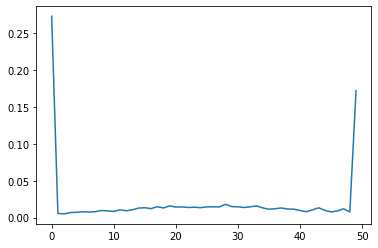

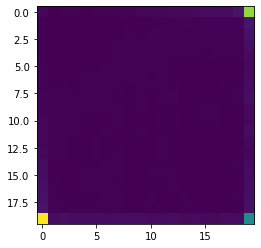

In [18]:
import torch
#from utility import ptcolor as ptcolor
"""
Relu_Softmax_LAB: This collections of methods compute the softmax (on channel L or AB) using the principles:
high value for taller bins and very low values for shorter bins ( almost 0 everywhere).
"""

def softquant(x, vmin, vmax, bins):
    slope = (bins - 1) / (vmax - vmin)
    a = torch.linspace(vmin, vmax, bins, device=x.device)
    diff = (x.unsqueeze(-1) - a).abs()
    return torch.nn.functional.relu(1 - diff * slope) #high value for taller bins, everywhere else almost 0

def softhist_L(x, vmin, vmax, bins):
    x = torch.clamp(x, vmin, vmax)
    q = softquant(x, vmin, vmax, bins)
    return q.view(x.size(0), -1, bins).mean(1)


def softhist_AB(lab, vmax, bins):
    a = torch.clamp(lab[:, 1, :, :], -vmax, vmax)
    b = torch.clamp(lab[:, 2, :, :], -vmax, vmax)
    qa = softquant(a, -vmax, vmax, bins).to(device=lab.device)
    qb = softquant(b, -vmax, vmax, bins).to(lab.device)
    return torch.einsum("bijc,bijd->bcd", qa, qb).to(lab.device) / (a.size(1) * a.size(2))

#ptcolor.py
def _t(data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return torch.tensor(data, requires_grad=False, dtype=torch.float32, device=device)


# Helper for color matrix multiplication
def _mul(coeffs, image):
    coeffs = coeffs.to(image.device).view(3, 3, 1, 1)
    return torch.nn.functional.conv2d(image, coeffs)


_RGB_TO_XYZ = {
    "srgb": _t([[0.4124564, 0.3575761, 0.1804375],
                [0.2126729, 0.7151522, 0.0721750],
                [0.0193339, 0.1191920, 0.9503041]]),

    "prophoto": _t([[0.7976749, 0.1351917, 0.0313534],
                    [0.2880402, 0.7118741, 0.0000857],
                    [0.0000000, 0.0000000, 0.8252100]])

    }


_XYZ_TO_RGB = {
    "srgb": _t([[3.2404542, -1.5371385, -0.4985314],
                   [-0.9692660, 1.8760108, 0.0415560],
                   [0.0556434, -0.2040259, 1.0572252]]),

    "prophoto": _t([[ 1.3459433, -0.2556075, -0.0511118],
                    [-0.5445989,  1.5081673,  0.0205351],
                    [0.0000000,  0.0000000,  1.2118128]])
    }


WHITE_POINTS = {item[0]: _t(item[1:]).view(1, 3, 1, 1) for item in [
    ("a", 1.0985, 1.0000, 0.3558),
    ("b", 0.9807, 1.0000, 1.1822),
    ("e", 1.0000, 1.0000, 1.0000),
    ("d50", 0.9642, 1.0000, 0.8251),
    ("d55", 0.9568, 1.0000, 0.9214),
    ("d65", 0.9504, 1.0000, 1.0888),
    ("icc", 0.9642, 1.0000, 0.8249)
]}


_EPSILON = 0.008856
_KAPPA = 903.3
_XYZ_TO_LAB = _t([[0.0, 116.0, 0.], [500.0, -500.0, 0.], [0.0, 200.0, -200.0]])
_LAB_TO_XYZ = _t([[1.0 / 116.0, 1.0 / 500.0, 0], [1.0 / 116.0, 0, 0], [1.0 / 116.0, 0, -1.0 / 200.0]])
_LAB_OFF = _t([16.0, 0.0, 0.0]).view(1, 3, 1, 1)


def apply_gamma(rgb, gamma="srgb"):
    """Linear to gamma rgb.
    Assume that rgb values are in the [0, 1] range (but values outside are tolerated).
    gamma can be "srgb", a real-valued exponent, or None.
    >>> apply_gamma(torch.tensor([0.5, 0.4, 0.1]).view([1, 3, 1, 1]), 0.5).view(-1)
    tensor([0.2500, 0.1600, 0.0100])
    """
    if gamma == "srgb":
        T = 0.0031308
        rgb1 = torch.max(rgb, rgb.new_tensor(T))
        return torch.where(rgb < T, 12.92 * rgb, (1.055 * torch.pow(torch.abs(rgb1), 1 / 2.4) - 0.055))
    elif gamma is None:
        return rgb
    else:
        return torch.pow(torch.max(rgb, rgb.new_tensor(0.0)), 1.0 / gamma)



def remove_gamma(rgb, gamma="srgb"):
    """Gamma to linear rgb.
    Assume that rgb values are in the [0, 1] range (but values outside are tolerated).
    gamma can be "srgb", a real-valued exponent, or None.
    >>> remove_gamma(apply_gamma(torch.tensor([0.001, 0.3, 0.4])))
    tensor([0.0010,  0.3000,  0.4000])
    >>> remove_gamma(torch.tensor([0.5, 0.4, 0.1]).view([1, 3, 1, 1]), 2.0).view(-1)
    tensor([0.2500, 0.1600, 0.0100])
    """
    if gamma == "srgb":
        T = 0.04045
        rgb1 = torch.max(rgb, rgb.new_tensor(T))
        return torch.where(rgb < T, rgb / 12.92, torch.pow(torch.abs(rgb1 + 0.055) / 1.055, 2.4))
    elif gamma is None:
        return rgb
    else:
        res = torch.pow(torch.max(rgb, rgb.new_tensor(0.0)), gamma) + \
              torch.min(rgb, rgb.new_tensor(0.0)) # very important to avoid vanishing gradients
        return res


def rgb2xyz(rgb, gamma_correction="srgb", clip_rgb=False, space="srgb"):
    """sRGB to XYZ conversion.
    rgb:  Bx3xHxW
    return: Bx3xHxW
    >>> rgb2xyz(torch.tensor([0., 0., 0.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.,  0.,  0.])
    >>> rgb2xyz(torch.tensor([0., 0.75, 0.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.1868,  0.3737,  0.0623])
    >>> rgb2xyz(torch.tensor([0.4, 0.8, 0.2]).view(1, 3, 1, 1), gamma_correction=None).view(-1)
    tensor([0.4871,  0.6716,  0.2931])
    >>> rgb2xyz(torch.ones(2, 3, 4, 5)).size()
    torch.Size([2, 3, 4, 5])
    >>> xyz2rgb(torch.tensor([-1, 2., 0.]).view(1, 3, 1, 1), clip_rgb=True).view(-1)
    tensor([0.0000,  1.0000,  0.0000])
    >>> rgb2xyz(torch.tensor([0.4, 0.8, 0.2]).view(1, 3, 1, 1), gamma_correction=None, space='prophoto').view(-1)
    tensor([0.4335,  0.6847,  0.1650])
    """
    if clip_rgb:
        rgb = torch.clamp(rgb, 0, 1)
    rgb = remove_gamma(rgb, gamma_correction)
    return _mul(_RGB_TO_XYZ[space], rgb)


def xyz2rgb(xyz, gamma_correction="srgb", clip_rgb=False, space="srgb"):
    """XYZ to sRGB conversion.
    rgb:  Bx3xHxW
    return: Bx3xHxW
    >>> xyz2rgb(torch.tensor([0., 0., 0.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.,  0.,  0.])
    >>> xyz2rgb(torch.tensor([0.04, 0.02, 0.05]).view(1, 3, 1, 1)).view(-1)
    tensor([0.3014,  0.0107,  0.2503])
    >>> xyz2rgb(torch.ones(2, 3, 4, 5)).size()
    torch.Size([2, 3, 4, 5])
    >>> xyz2rgb(torch.tensor([-1, 2., 0.]).view(1, 3, 1, 1), clip_rgb=True).view(-1)
    tensor([0.0000,  1.0000,  0.0000])
    """
    rgb = _mul(_XYZ_TO_RGB[space], xyz)
    if clip_rgb:
        rgb = torch.clamp(rgb, 0, 1)
    rgb = apply_gamma(rgb, gamma_correction)
    return rgb


def _lab_f(x):
    x1 = torch.max(x, x.new_tensor(_EPSILON))
    return torch.where(x > _EPSILON, torch.pow(x1, 1.0 / 3), (_KAPPA * x + 16.0) / 116.0)


def xyz2lab(xyz, white_point="d65"):
    """XYZ to Lab conversion.
    xyz: Bx3xHxW
    return: Bx3xHxW
    >>> xyz2lab(torch.tensor([0., 0., 0.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.,  0.,  0.])
    >>> xyz2lab(torch.tensor([0.4, 0.2, 0.1]).view(1, 3, 1, 1)).view(-1)
    tensor([51.8372,  82.3018,  26.7245])
    >>> xyz2lab(torch.tensor([1., 1., 1.]).view(1, 3, 1, 1), white_point="e").view(-1)
    tensor([100., 0., 0.])
    """
    xyz = xyz / WHITE_POINTS[white_point].to(xyz.device)
    f_xyz = _lab_f(xyz)
    return _mul(_XYZ_TO_LAB, f_xyz) - _LAB_OFF.to(xyz.device)


def _inv_lab_f(x):
    x3 = torch.max(x, x.new_tensor(_EPSILON)) ** 3
    return torch.where(x3 > _EPSILON, x3, (116.0 * x - 16.0) / _KAPPA)


def lab2xyz(lab, white_point="d65"):
    """lab to XYZ conversion.
    lab: Bx3xHxW
    return: Bx3xHxW
    >>> lab2xyz(torch.tensor([0., 0., 0.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.,  0.,  0.])
    >>> lab2xyz(torch.tensor([100., 0., 0.]).view(1, 3, 1, 1), white_point="e").view(-1)
    tensor([1.,  1.,  1.])
    >>> lab2xyz(torch.tensor([50., 25., -30.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.2254,  0.1842,  0.4046])
    """
    f_xyz = _mul(_LAB_TO_XYZ, lab + _LAB_OFF.to(lab.device))
    xyz = _inv_lab_f(f_xyz)
    return xyz * WHITE_POINTS[white_point].to(lab.device)


def rgb2lab(rgb, white_point="d65", gamma_correction="srgb", clip_rgb=False, space="srgb"):
    """sRGB to Lab conversion."""
    lab = xyz2lab(rgb2xyz(rgb, gamma_correction, clip_rgb, space), white_point)
    return lab


def lab2rgb(rgb, white_point="d65", gamma_correction="srgb", clip_rgb=False, space="srgb"):
    """Lab to sRGB conversion."""
    return xyz2rgb(lab2xyz(rgb, white_point), gamma_correction, clip_rgb, space)

def lab2lch(lab):
    """Lab to LCH conversion."""
    l = lab[:, 0, :, :]
    c = torch.norm(lab[:, 1:, :, :], 2, 1)
    h = torch.atan2(lab[:, 2, :, :], lab[:, 1, :, :])
    h = h * (180 / 3.141592653589793)
    h = torch.where(h >= 0, h, 360 + h)
    return torch.stack([l, c, h], 1)


def rgb2lch(rgb, white_point="d65", gamma_correction="srgb", clip_rgb=False, space="srgb"):
    """sRGB to LCH conversion."""
    lab = rgb2lab(rgb, white_point, gamma_correction, clip_rgb, space)
    return lab2lch(lab)

def squared_deltaE(lab1, lab2):
    """Squared Delta E (CIE 1976).
    lab1: Bx3xHxW
    lab2: Bx3xHxW
    return: Bx1xHxW
    """
    return torch.sum((lab1 - lab2) ** 2, 1, keepdim=True)


def deltaE(lab1, lab2):
    """Delta E (CIE 1976).
    lab1: Bx3xHxW
    lab2: Bx3xHxW
    return: Bx1xHxW
    >>> lab1 = torch.tensor([100., 75., 50.]).view(1, 3, 1, 1)
    >>> lab2 = torch.tensor([50., 50., 100.]).view(1, 3, 1, 1)
    >>> deltaE(lab1, lab2).item()
    75.0
    """
    return torch.norm(lab1 - lab2, 2, 1, keepdim=True)


def squared_deltaE94(lab1, lab2):
    """Squared Delta E (CIE 1994).
    Default parameters for the 'Graphic Art' version.
    lab1: Bx3xHxW   (reference color)
    lab2: Bx3xHxW   (other color)
    return: Bx1xHxW
    """
    diff_2 = (lab1 - lab2) ** 2
    dl_2 = diff_2[:, 0:1, :, :]
    c1 = torch.norm(lab1[:, 1:3, :, :], 2, 1, keepdim=True)
    c2 = torch.norm(lab2[:, 1:3, :, :], 2, 1, keepdim=True)
    dc_2 = (c1 - c2) ** 2
    dab_2 = torch.sum(diff_2[:, 1:3, :, :], 1, keepdim=True)
    dh_2 = torch.abs(dab_2 - dc_2)
    de_2 = (dl_2 +
            dc_2 / ((1 + 0.045 * c1) ** 2) +
            dh_2 / ((1 + 0.015 * c1) ** 2))
    return de_2


def deltaE94(lab1, lab2):
    """Delta E (CIE 1994).
    Default parameters for the 'Graphic Art' version.
    lab1: Bx3xHxW   (reference color)
    lab2: Bx3xHxW   (other color)
    return: Bx1xHxW
    >>> lab1 = torch.tensor([100., 0., 0.]).view(1, 3, 1, 1)
    >>> lab2 = torch.tensor([80., 0., 0.]).view(1, 3, 1, 1)
    >>> deltaE94(lab1, lab2).item()
    20.0
    >>> lab1 = torch.tensor([100., 0., 0.]).view(1, 3, 1, 1)
    >>> lab2 = torch.tensor([100., 20., 0.]).view(1, 3, 1, 1)
    >>> deltaE94(lab1, lab2).item()
    20.0
    >>> lab1 = torch.tensor([100., 0., 10.]).view(1, 3, 1, 1)
    >>> lab2 = torch.tensor([100., 0., 0.]).view(1, 3, 1, 1)
    >>> round(deltaE94(lab1, lab2).item(), 4)
    6.8966
    >>> lab1 = torch.tensor([100., 75., 50.]).view(1, 3, 1, 1)
    >>> lab2 = torch.tensor([50., 50., 100.]).view(1, 3, 1, 1)
    >>> round(deltaE94(lab1, lab2).item(), 4)
    54.7575
    """
    # The ReLU prevents from NaNs in gradient computation
    sq = torch.nn.functional.relu(squared_deltaE94(lab1, lab2))
    return torch.sqrt(sq)


def _check_conversion(**opts):
    """Verify the conversions on the RGB cube.
    >>> _check_conversion(white_point='d65', gamma_correction='srgb', clip_rgb=False, space='srgb')
    True
    >>> _check_conversion(white_point='d50', gamma_correction=1.8, clip_rgb=False, space='prophoto')
    True
    """
    for r in range(0, 256, 15):
        for g in range(0, 256, 15):
            for b in range(0, 256, 15):
                rgb = torch.tensor([r / 255.0, g / 255.0, b / 255.0]).view(1, 3, 1, 1)
                lab = rgb2lab(rgb, **opts)
                rgb2 = lab2rgb(lab, **opts)
                de = deltaE(rgb, rgb2).item()
                if de > 2e-4:
                    print("Conversion failed for RGB:", r, g, b, " deltaE", de)
                    return False
    return True
#ptcolor.end

if __name__ == "__main__":

    import matplotlib.pyplot as plt

    im = torch.randn([1,3,64,64])
    lab = rgb2lab(im)
    for c in (0, 1, 2):
        print(lab[:, c, :, :].min(), lab[:, c, :, :].max())
    hist_l = softhist_L(lab[:, 0, :, :], 0, 100, 50)
    print(hist_l.shape)
    hist_ab = softhist_AB(lab, 80, 20)
    plt.plot(hist_l[0].numpy())
    plt.figure()
    plt.imshow(hist_ab[0].numpy())
    plt.show()

In [19]:
from torch.utils import data
import torchvision.transforms as transforms
import torch
import os
from PIL import Image

"""
Five K Dataset: 
    constructor params: 
        -list_file: path of a file with the list of images
        -raw_dir: path of the directory which contains raw images
        -expert_dir: path of the directory which contains expert images
        -training: if True, horizontal flip is applied
        -size: if is not None, resize is applied
        -filenames, if is true, __getitem__ returns also the name of the image taken  
"""

class FiveKDataset(data.Dataset):
    def __init__(self, list_file, raw_dir, expert_dir, training, size=None, filenames=False):
        join = os.path.join
        self.file_list = []
        with open(list_file) as f:
            for line in f:
                name = line.strip()
                if name:
                    p = (join(raw_dir, name), join(expert_dir, name), name)
                    self.file_list.append(p)
        self.filenames = filenames
        transformation=[]
        if size is not None:
          transformation.append(transforms.Resize((size,size)))
        if training:
          transformation.append(transforms.RandomHorizontalFlip(0.5))
        transformation.append(transforms.ToTensor())
        self.transform=transforms.Compose(transformation)

    def __len__(self):
        return len(self.file_list)

   # def __getitem__(self, index):
    #    raw = Image.open(self.file_list[index][0])
     #   expert =  Image.open(self.file_list[index][1])
      #  raw_exp = self.transform(torch.stack([raw, expert]))
       # if self.filenames:
        #    return raw_exp[0],raw_exp[1], self.file_list[index][2]
        #else:
         #   return raw_exp[0],raw_exp[1]


def _test():
    train_list = "/content/test1.txt"
    raw_dir = "/content/drive/MyDrive/deepwaterdetection/U-shape_Transformer_for_Underwater_Image_Enhancement-main/test1"
    expert_dir = "/content/drive/MyDrive/deepwaterdetection/U-shape_Transformer_for_Underwater_Image_Enhancement-main/test1"
    dataset = FiveKDataset(train_list, raw_dir, expert_dir, True, None)
    loader = torch.utils.data.DataLoader(dataset, 10, shuffle=True,num_workers=16)
    for raw, expert in loader:
        print(raw.size(), expert.size())



def _test():
    train_list = "/content/train1.txt"
    raw_dir = "/content/drive/MyDrive/deepwaterdetection/U-shape_Transformer_for_Underwater_Image_Enhancement-main/train1"
    expert_dir = "/content/drive/MyDrive/deepwaterdetection/U-shape_Transformer_for_Underwater_Image_Enhancement-main/train1"
    dataset = FiveKDataset(train_list, raw_dir, expert_dir, True, None)
    loader = torch.utils.data.DataLoader(dataset, 10, shuffle=True)
    #for raw, expert in loader:
     #   print(raw.size(), expert.size())


if __name__ == '__main__':
    _test()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


(256, 256, 3) uint8


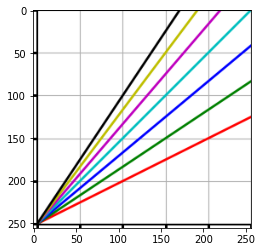

In [21]:
import matplotlib
if __name__ != "__main__":
    matplotlib.use('agg')
import matplotlib.pyplot as plt
import numpy as np


def make_plots(data, height, width, dpi=100.0, rgbonly=False):
    n = data.shape[1]
    x = np.linspace(0, 1, n)
    fig = plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    plt.grid()
    styles = ["r-", "g-", "b-", "c-", "m-", "y-", "k-"]
    if rgbonly:
        styles = styles[:3]
    for y, style in zip(data, styles):
        plt.plot(x, y, style, lw=2)
    ax = plt.gca()
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    plt.tick_params(axis='both', which='both', labelbottom=False,
                    labelleft=False)
    fig.tight_layout(pad=0)
    fig.canvas.draw()
    bin = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
    w, h = fig.canvas.get_width_height()
    plt.close()
    return bin.reshape([h, w, 3])


def make_test_image(samples, batch_size):
    a = np.linspace(0, 1, samples, dtype=np.float32)
    z = np.zeros_like(a)
    im = np.stack([a, z, z,
                   z, a, z,
                   z, z, a,
                   z, a, a,
                   a, z, a,
                   a, a, z,
                   a, a, a])
    im = im.reshape([7, 3, samples])
    im = im.transpose([1, 0, 2])
    im = np.tile(im[None, :], [batch_size, 1, 1, 1])
    return im


def plots_from_test_image(im, height, width, rgbonly=False):
    channels = [im[:, 0, 0, :],
                im[:, 1, 1, :],
                im[:, 2, 2, :]]
    channels.append((channels[1] + channels[2]) / 2)
    channels.append((channels[0] + channels[2]) / 2)
    channels.append((channels[0] + channels[1]) / 2)
    channels.append((channels[0] + channels[1] + channels[2]) / 3)
    im = np.stack(channels, 1)
    n = im.shape[0]
    pls = [make_plots(im[i, :], height, width, rgbonly=rgbonly) for i in range(n)]
    return np.stack(pls, 0).transpose([0, 3, 1, 2]) / 255.0


def _main():
    data = np.outer(np.arange(3, 10), np.arange(11)) / 60.0
    # data = np.random.rand(7, 10)
    im = make_plots(data, 256, 256)
    print(im.shape, im.dtype)
    plt.imshow(im)
    plt.show()


if __name__ == "__main__":
    _main()

In [22]:
import torch
from PIL import Image
from torchvision import transforms, utils
import os,sys
import numpy as np


# Helper for the creation of module-global constant tensors
def _t(data):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    return torch.tensor(data, requires_grad=False, dtype=torch.float32, device=device)


# Helper for color matrix multiplication
def _mul(coeffs, image):
    coeffs = coeffs.to(image.device).view(3, 3, 1, 1)
    return torch.nn.functional.conv2d(image, coeffs)


_RGB_TO_XYZ = {
    "srgb": _t([[0.4124564, 0.3575761, 0.1804375],
                [0.2126729, 0.7151522, 0.0721750],
                [0.0193339, 0.1191920, 0.9503041]]),

    "prophoto": _t([[0.7976749, 0.1351917, 0.0313534],
                    [0.2880402, 0.7118741, 0.0000857],
                    [0.0000000, 0.0000000, 0.8252100]])

    }


_XYZ_TO_RGB = {
    "srgb": _t([[3.2404542, -1.5371385, -0.4985314],
                   [-0.9692660, 1.8760108, 0.0415560],
                   [0.0556434, -0.2040259, 1.0572252]]),

    "prophoto": _t([[ 1.3459433, -0.2556075, -0.0511118],
                    [-0.5445989,  1.5081673,  0.0205351],
                    [0.0000000,  0.0000000,  1.2118128]])
    }


WHITE_POINTS = {item[0]: _t(item[1:]).view(1, 3, 1, 1) for item in [
    ("a", 1.0985, 1.0000, 0.3558),
    ("b", 0.9807, 1.0000, 1.1822),
    ("e", 1.0000, 1.0000, 1.0000),
    ("d50", 0.9642, 1.0000, 0.8251),
    ("d55", 0.9568, 1.0000, 0.9214),
    ("d65", 0.9504, 1.0000, 1.0888),
    ("icc", 0.9642, 1.0000, 0.8249)
]}


_EPSILON = 0.008856
_KAPPA = 903.3
_XYZ_TO_LAB = _t([[0.0, 116.0, 0.], [500.0, -500.0, 0.], [0.0, 200.0, -200.0]])
_LAB_TO_XYZ = _t([[1.0 / 116.0, 1.0 / 500.0, 0], [1.0 / 116.0, 0, 0], [1.0 / 116.0, 0, -1.0 / 200.0]])
_LAB_OFF = _t([16.0, 0.0, 0.0]).view(1, 3, 1, 1)


def apply_gamma(rgb, gamma="srgb"):
    """Linear to gamma rgb.
    Assume that rgb values are in the [0, 1] range (but values outside are tolerated).
    gamma can be "srgb", a real-valued exponent, or None.
    >>> apply_gamma(torch.tensor([0.5, 0.4, 0.1]).view([1, 3, 1, 1]), 0.5).view(-1)
    tensor([0.2500, 0.1600, 0.0100])
    """
    if gamma == "srgb":
        T = 0.0031308
        rgb1 = torch.max(rgb, rgb.new_tensor(T))
        return torch.where(rgb < T, 12.92 * rgb, (1.055 * torch.pow(torch.abs(rgb1), 1 / 2.4) - 0.055))
    elif gamma is None:
        return rgb
    else:
        return torch.pow(torch.max(rgb, rgb.new_tensor(0.0)), 1.0 / gamma)



def remove_gamma(rgb, gamma="srgb"):
    """Gamma to linear rgb.
    Assume that rgb values are in the [0, 1] range (but values outside are tolerated).
    gamma can be "srgb", a real-valued exponent, or None.
    >>> remove_gamma(apply_gamma(torch.tensor([0.001, 0.3, 0.4])))
    tensor([0.0010,  0.3000,  0.4000])
    >>> remove_gamma(torch.tensor([0.5, 0.4, 0.1]).view([1, 3, 1, 1]), 2.0).view(-1)
    tensor([0.2500, 0.1600, 0.0100])
    """
    if gamma == "srgb":
        T = 0.04045
        rgb1 = torch.max(rgb, rgb.new_tensor(T))
        return torch.where(rgb < T, rgb / 12.92, torch.pow(torch.abs(rgb1 + 0.055) / 1.055, 2.4))
    elif gamma is None:
        return rgb
    else:
        res = torch.pow(torch.max(rgb, rgb.new_tensor(0.0)), gamma) + \
              torch.min(rgb, rgb.new_tensor(0.0)) # very important to avoid vanishing gradients
        return res


def rgb2xyz(rgb, gamma_correction="srgb", clip_rgb=False, space="srgb"):
    """sRGB to XYZ conversion.
    rgb:  Bx3xHxW
    return: Bx3xHxW
    >>> rgb2xyz(torch.tensor([0., 0., 0.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.,  0.,  0.])
    >>> rgb2xyz(torch.tensor([0., 0.75, 0.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.1868,  0.3737,  0.0623])
    >>> rgb2xyz(torch.tensor([0.4, 0.8, 0.2]).view(1, 3, 1, 1), gamma_correction=None).view(-1)
    tensor([0.4871,  0.6716,  0.2931])
    >>> rgb2xyz(torch.ones(2, 3, 4, 5)).size()
    torch.Size([2, 3, 4, 5])
    >>> xyz2rgb(torch.tensor([-1, 2., 0.]).view(1, 3, 1, 1), clip_rgb=True).view(-1)
    tensor([0.0000,  1.0000,  0.0000])
    >>> rgb2xyz(torch.tensor([0.4, 0.8, 0.2]).view(1, 3, 1, 1), gamma_correction=None, space='prophoto').view(-1)
    tensor([0.4335,  0.6847,  0.1650])
    """
    if clip_rgb:
        rgb = torch.clamp(rgb, 0, 1)
    rgb = remove_gamma(rgb, gamma_correction)
    return _mul(_RGB_TO_XYZ[space], rgb)


def xyz2rgb(xyz, gamma_correction="srgb", clip_rgb=False, space="srgb"):
    """XYZ to sRGB conversion.
    rgb:  Bx3xHxW
    return: Bx3xHxW
    >>> xyz2rgb(torch.tensor([0., 0., 0.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.,  0.,  0.])
    >>> xyz2rgb(torch.tensor([0.04, 0.02, 0.05]).view(1, 3, 1, 1)).view(-1)
    tensor([0.3014,  0.0107,  0.2503])
    >>> xyz2rgb(torch.ones(2, 3, 4, 5)).size()
    torch.Size([2, 3, 4, 5])
    >>> xyz2rgb(torch.tensor([-1, 2., 0.]).view(1, 3, 1, 1), clip_rgb=True).view(-1)
    tensor([0.0000,  1.0000,  0.0000])
    """
    rgb = _mul(_XYZ_TO_RGB[space], xyz)
    if clip_rgb:
        rgb = torch.clamp(rgb, 0, 1)
    rgb = apply_gamma(rgb, gamma_correction)
    return rgb


def _lab_f(x):
    x1 = torch.max(x, x.new_tensor(_EPSILON))
    return torch.where(x > _EPSILON, torch.pow(x1, 1.0 / 3), (_KAPPA * x + 16.0) / 116.0)


def xyz2lab(xyz, white_point="d65"):
    """XYZ to Lab conversion.
    xyz: Bx3xHxW
    return: Bx3xHxW
    >>> xyz2lab(torch.tensor([0., 0., 0.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.,  0.,  0.])
    >>> xyz2lab(torch.tensor([0.4, 0.2, 0.1]).view(1, 3, 1, 1)).view(-1)
    tensor([51.8372,  82.3018,  26.7245])
    >>> xyz2lab(torch.tensor([1., 1., 1.]).view(1, 3, 1, 1), white_point="e").view(-1)
    tensor([100., 0., 0.])
    """
    xyz = xyz / WHITE_POINTS[white_point].to(xyz.device)
    f_xyz = _lab_f(xyz)
    return _mul(_XYZ_TO_LAB, f_xyz) - _LAB_OFF.to(xyz.device)


def _inv_lab_f(x):
    x3 = torch.max(x, x.new_tensor(_EPSILON)) ** 3
    return torch.where(x3 > _EPSILON, x3, (116.0 * x - 16.0) / _KAPPA)


def lab2xyz(lab, white_point="d65"):
    """lab to XYZ conversion.
    lab: Bx3xHxW
    return: Bx3xHxW
    >>> lab2xyz(torch.tensor([0., 0., 0.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.,  0.,  0.])
    >>> lab2xyz(torch.tensor([100., 0., 0.]).view(1, 3, 1, 1), white_point="e").view(-1)
    tensor([1.,  1.,  1.])
    >>> lab2xyz(torch.tensor([50., 25., -30.]).view(1, 3, 1, 1)).view(-1)
    tensor([0.2254,  0.1842,  0.4046])
    """
    f_xyz = _mul(_LAB_TO_XYZ, lab + _LAB_OFF.to(lab.device))
    xyz = _inv_lab_f(f_xyz)
    return xyz * WHITE_POINTS[white_point].to(lab.device)


def rgb2lab(rgb, white_point="d65", gamma_correction="srgb", clip_rgb=False, space="srgb"):
    """sRGB to Lab conversion."""
    lab = xyz2lab(rgb2xyz(rgb, gamma_correction, clip_rgb, space), white_point)
    return lab


def lab2rgb(rgb, white_point="d65", gamma_correction="srgb", clip_rgb=False, space="srgb"):
    """Lab to sRGB conversion."""
    return xyz2rgb(lab2xyz(rgb, white_point), gamma_correction, clip_rgb, space)

def lab2lch(lab):
    """Lab to LCH conversion."""
    l = lab[:, 0, :, :]
    c = torch.norm(lab[:, 1:, :, :], 2, 1)
    h = torch.atan2(lab[:, 2, :, :], lab[:, 1, :, :])
    h = h * (180 / 3.141592653589793)
    h = torch.where(h >= 0, h, 360 + h)
    return torch.stack([l, c, h], 1)


def rgb2lch(rgb, white_point="d65", gamma_correction="srgb", clip_rgb=False, space="srgb"):
    """sRGB to LCH conversion."""
    lab = rgb2lab(rgb, white_point, gamma_correction, clip_rgb, space)
    return lab2lch(lab)

def squared_deltaE(lab1, lab2):
    """Squared Delta E (CIE 1976).
    lab1: Bx3xHxW
    lab2: Bx3xHxW
    return: Bx1xHxW
    """
    return torch.sum((lab1 - lab2) ** 2, 1, keepdim=True)


def deltaE(lab1, lab2):
    """Delta E (CIE 1976).
    lab1: Bx3xHxW
    lab2: Bx3xHxW
    return: Bx1xHxW
    >>> lab1 = torch.tensor([100., 75., 50.]).view(1, 3, 1, 1)
    >>> lab2 = torch.tensor([50., 50., 100.]).view(1, 3, 1, 1)
    >>> deltaE(lab1, lab2).item()
    75.0
    """
    return torch.norm(lab1 - lab2, 2, 1, keepdim=True)


def squared_deltaE94(lab1, lab2):
    """Squared Delta E (CIE 1994).
    Default parameters for the 'Graphic Art' version.
    lab1: Bx3xHxW   (reference color)
    lab2: Bx3xHxW   (other color)
    return: Bx1xHxW
    """
    diff_2 = (lab1 - lab2) ** 2
    dl_2 = diff_2[:, 0:1, :, :]
    c1 = torch.norm(lab1[:, 1:3, :, :], 2, 1, keepdim=True)
    c2 = torch.norm(lab2[:, 1:3, :, :], 2, 1, keepdim=True)
    dc_2 = (c1 - c2) ** 2
    dab_2 = torch.sum(diff_2[:, 1:3, :, :], 1, keepdim=True)
    dh_2 = torch.abs(dab_2 - dc_2)
    de_2 = (dl_2 +
            dc_2 / ((1 + 0.045 * c1) ** 2) +
            dh_2 / ((1 + 0.015 * c1) ** 2))
    return de_2


def deltaE94(lab1, lab2):
    """Delta E (CIE 1994).
    Default parameters for the 'Graphic Art' version.
    lab1: Bx3xHxW   (reference color)
    lab2: Bx3xHxW   (other color)
    return: Bx1xHxW
    >>> lab1 = torch.tensor([100., 0., 0.]).view(1, 3, 1, 1)
    >>> lab2 = torch.tensor([80., 0., 0.]).view(1, 3, 1, 1)
    >>> deltaE94(lab1, lab2).item()
    20.0
    >>> lab1 = torch.tensor([100., 0., 0.]).view(1, 3, 1, 1)
    >>> lab2 = torch.tensor([100., 20., 0.]).view(1, 3, 1, 1)
    >>> deltaE94(lab1, lab2).item()
    20.0
    >>> lab1 = torch.tensor([100., 0., 10.]).view(1, 3, 1, 1)
    >>> lab2 = torch.tensor([100., 0., 0.]).view(1, 3, 1, 1)
    >>> round(deltaE94(lab1, lab2).item(), 4)
    6.8966
    >>> lab1 = torch.tensor([100., 75., 50.]).view(1, 3, 1, 1)
    >>> lab2 = torch.tensor([50., 50., 100.]).view(1, 3, 1, 1)
    >>> round(deltaE94(lab1, lab2).item(), 4)
    54.7575
    """
    # The ReLU prevents from NaNs in gradient computation
    sq = torch.nn.functional.relu(squared_deltaE94(lab1, lab2))
    return torch.sqrt(sq)


def _check_conversion(**opts):
    """Verify the conversions on the RGB cube.
    >>> _check_conversion(white_point='d65', gamma_correction='srgb', clip_rgb=False, space='srgb')
    True
    >>> _check_conversion(white_point='d50', gamma_correction=1.8, clip_rgb=False, space='prophoto')
    True
    """
    for r in range(0, 256, 15):
        for g in range(0, 256, 15):
            for b in range(0, 256, 15):
                rgb = torch.tensor([r / 255.0, g / 255.0, b / 255.0]).view(1, 3, 1, 1)
                lab = rgb2lab(rgb, **opts)
                rgb2 = lab2rgb(lab, **opts)
                de = deltaE(rgb, rgb2).item()
                if de > 2e-4:
                    print("Conversion failed for RGB:", r, g, b, " deltaE", de)
                    return False
    return True


def _check_gradients():
    """Verify some borderline gradient computation
    >>> a = torch.zeros(1, 3, 1, 1, requires_grad=True)
    >>> b = torch.zeros(1, 3, 1, 1, requires_grad=True)
    >>> deltaE(a, b).backward()
    >>> torch.any(torch.isnan(a.grad)).item()
    0
    >>> torch.any(torch.isnan(b.grad)).item()
    0
    >>> deltaE94(a, b).backward()
    >>> torch.any(torch.isnan(a.grad)).item()
    0
    >>> torch.any(torch.isnan(b.grad)).item()
    0
    """
    return True


if __name__ == '__main__':
    import doctest
    doctest.testmod(optionflags=doctest.NORMALIZE_WHITESPACE)
    print("Test completed")


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/doctest.py", line 1487, in run
    sys.settrace(save_trace)



Test completed


In [23]:
import time
import math
import collections


class Display:
    """Write on terminal statistics in a fancy way.
    Colors are used to signal variations in the data.
    Example:
    
    display = Display("Step {step}/{}   loss: {loss:.2f}")
    display.disp(10, 100, loss=3.14159)
    It would print the message:
    Step 10/100    loss 3.14
    with "3.14" colored according to historical variation of the loss
    value.
    Named fields (such as "loss") are tracked and displayed in color.
    Unnamed fields are not tracked.  "step" is a special untracked field,
    and "steps_s" is a tracked field that is automatically computed.
    
    """
    def __init__(self, format_string):
        """Create the display object.
        The format string encodes how information should be displayed.
        """
        self.fmt = format_string
        self.vars_ = collections.defaultdict(_DisplayVar)
        self.steps_s = _DisplayVar()
        self.last_step = None
        self.last_time = None

    def message(self, step, *fields, **data):
        """Compose a message with the given information."""
        self._update_steps_s(step)
        d = dict((k, self._update_var(k, v)) for (k, v) in data.items())
        return self.fmt.format(*fields, step=step, steps_s=self.steps_s, **d)
        
    def disp(self, step, *fields, **data):
        """Print on stdout the given information according the the format of the display."""
        print(self.message(step, *fields, **data))

    def _update_var(self, k, v):
        dv = self.vars_[k]
        dv.add(v)
        return dv

    def _update_steps_s(self, step):
        tm = time.perf_counter()
        if self.last_step is None or self.last_time >= tm:
            speed = float("nan")
        else:
            speed = (step - self.last_step) / (tm - self.last_time)
        self.last_time = tm
        self.last_step = step
        self.steps_s.add(speed)


class _DisplayVar:
    """Track the history of a value and format its last value accordingly."""

    # Ansi codes for colors and styles
    MIN = "\x1B[1;32m"    # bold green
    LOW = "\x1B[0;32m"    # green
    NORMAL = "\x1B[0;33m" # yellow
    HIGH = "\x1B[0;31m"   # red
    MAX = "\x1B[1;31m"    # bold red
    NAN = "\x1B[1;36m"    # cyan
    RESET = "\x1B[0m"     # default style
    
    def __init__(self, history_len=10):
        """Initialize the object.
        Remembers up to history_len values.
        """
        self.history = collections.deque(maxlen=history_len)
        self.minval = self.maxval = None
        self.lastvalue = float("nan")
        self.state = self.NAN
        
    def add(self, value):
        """Add a new value to the series."""
        self.lastvalue = value
        if math.isnan(value):
            self.state = self.NAN
        elif not self.history:
            self.state = self.NORMAL
            self.history.append(value)
            self.minval = self.maxval = value
        else:
            _, s = min((min(self.history), self.NORMAL), (value, self.LOW))
            _, s = max((max(self.history), s), (value, self.HIGH))
            self.maxval, _, s = max((self.maxval, 1, s), (value, 0, self.MAX))
            self.minval, _, s = min((self.minval, 0, s), (value, 1, self.MIN))
            self.state = s
            self.history.append(value)

    def __format__(self, spec):
        """Format the last added value."""
        s = self.lastvalue.__format__(spec)
        return self.state + s + self.RESET
    

def _demo():
    import random
    fmt = "Step: {step:3d}/{}  Loss: {loss:6.3f}  {steps_s:6.4f} steps/s"
    display = Display(fmt)
    for step in range(1, 101):
        time.sleep(1)
        display.disp(step, 100, loss=random.random() * 100)
    

if __name__ == "__main__":
    _demo()
    # session = Session("model_dir", save_every=100, save_count=5, state=[model, optimizer], max_epocs=3)
    # session.add_state(model)
    # session.add_state(optimizer)
    # session.restore()
    # for x ,y in session.train_loop(loader):
    #     session.step
    #     session.epoc

Step:   1/100  Loss: 34.908     nan steps/s
Step:   2/100  Loss: 80.505  0.9979 steps/s
Step:   3/100  Loss: 58.538  0.9980 steps/s
Step:   4/100  Loss: 96.274  0.9980 steps/s
Step:   5/100  Loss:  7.364  0.9987 steps/s
Step:   6/100  Loss: 27.467  0.9987 steps/s
Step:   7/100  Loss: 99.897  0.9988 steps/s
Step:   8/100  Loss: 42.141  0.9987 steps/s
Step:   9/100  Loss: 87.440  0.9987 steps/s
Step:  10/100  Loss: 17.401  0.9987 steps/s
Step:  11/100  Loss: 15.679  0.9985 steps/s
Step:  12/100  Loss:  6.522  0.9987 steps/s
Step:  13/100  Loss:  3.116  0.9987 steps/s
Step:  14/100  Loss: 81.512  0.9987 steps/s
Step:  15/100  Loss: 25.903  0.9987 steps/s
Step:  16/100  Loss: 67.678  0.9987 steps/s
Step:  17/100  Loss: 22.440  0.9987 steps/s
Step:  18/100  Loss: 17.955  0.9987 steps/s
Step:  19/100  Loss:  5.900  0.9987 steps/s
Step:  20/100  Loss: 24.537  0.9986 steps/s
Step:  21/100  Loss: 69.853  0.9988 steps/s
Step:  22/100  Loss: 32.757  0.9979 steps/s
Step:  23/100  Loss: 31.632  0.9

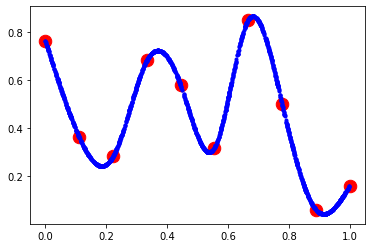

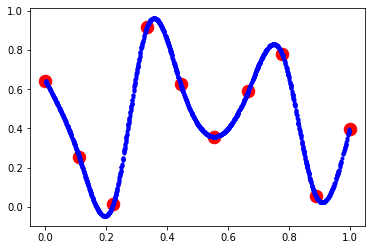

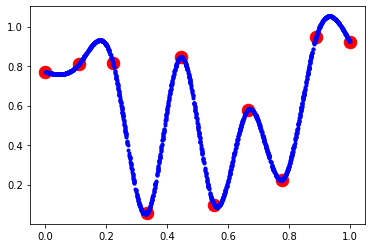

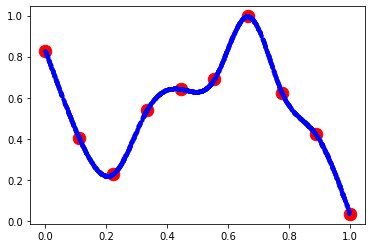

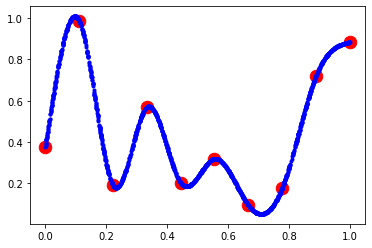

In [24]:
import torch
import numpy as np


class SplineInterpolator(torch.nn.Module):
    """Module performing spline interpolation.
    Splines are defined by a set of n nodes.  x coordinates of the
    nodes are assumed to be equispaced in the [0, 1] range.
    y coordinates of the nodes are part of the input.
    Given a different set of x coordinates, the module compute
    the interpolated y coordinates.
    """
    
    def __init__(self, nodes, dtype=torch.float32):
        """Create the object.
        Parameters
        ----------
        nodes : int
            number of nodes.
        dtype
            type of internal data.
        """
        super().__init__()
        A = self._precalc(nodes)
        self.register_buffer("A", torch.tensor(A, dtype=dtype))

    def _precalc(self, n):
        # Helper function computing the internal matrix A.
        h = 1.0 / (n - 1)
        mat = 4 * np.eye(n - 2)        
        np.fill_diagonal(mat[1:, :-1], 1)
        np.fill_diagonal(mat[:-1, 1:], 1)
        A = 6 * np.linalg.inv(mat) / (h ** 2)
        z = np.zeros(n - 2)
        A = np.vstack([z, A, z])

        B = np.zeros([n - 2, n])
        np.fill_diagonal(B, 1)
        np.fill_diagonal(B[:, 1:], -2)
        np.fill_diagonal(B[:, 2:], 1)
        A = np.dot(A, B)
        return A.T
        
    def _coefficients(self, y):
        # Helper function computing the coefficients of the polynomials
        # For the given y coordinates of the nodes.
        n = self.A.size(1)
        h = 1.0 / (n - 1)
        M = torch.mm(y, self.A)
        a = (M[:, 1:] - M[:, :-1]) / (6 * h)
        b = M[:, :-1] / 2
        c = (y[:, 1:] - y[:, :-1]) / h - (M[:, 1:] + 2 * M[:, :-1]) * (h / 6)
        return (a, b, c, y[:, :-1])

    def _apply(self, x, coeffs):
        # Helper function interpolating the splines at x.
        # coeffs is the list of coefficients of the polynomials.
        n = self.A.size(1)
        xv = x.view(x.size(0), -1)
        xi = torch.clamp(xv * (n - 1), 0, n - 2).long()
        xf = xv - xi.float() / (n - 1)
        a, b, c, d = (torch.gather(cc, 1, xi) for cc in coeffs)
        z = d + c * xf + b * (xf ** 2) + a * (xf ** 3)
        return z.view_as(x)

    def forward(self, y, x):
        """Interpolate values using splines.
        Parameters
        ----------
        y : tensor (b, n)
            y coordinates for the nodes (one set for each batch).
        x : tensor (b, m1, m2, ..., md)
            values to interpolats (one set for each batch).
        Returns
        -------
        tensor (b, m1, m2, ..., md)
            interpolated values.
        """
        return self._apply(x, self._coefficients(y))

    
def _demo():
    import matplotlib.pyplot as plt
    n = 10
    b = 5
    sp = SplineInterpolator(n)
    y = torch.rand((b, n))
    x = torch.rand((b, 20 * n, 10))
    z = sp(y, x)
    ax = np.linspace(0, 1, n)
    for i in range(b):
        plt.figure()
        plt.plot(ax, y[i, :].cpu().numpy(), 'r.', markersize=25)
        plt.plot(x[i, :].cpu().numpy(), z[i, :].cpu().numpy(), 'b.')
    plt.show()
    

if __name__ == '__main__':
    _demo()

In [25]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
#import pytorch_ssim
import  time 
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torch.nn.modules.loss import _Loss 
#from net.Ushape_Trans import *
#from dataset import prepare_data, Dataset
#from net.utils import *
import cv2
import matplotlib.pyplot as plt
#from utility import plots as plots, ptcolor as ptcolor, ptutils as ptutils, data as data
#from loss.LAB import *
#from loss.LCH import *

In [26]:

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [27]:
def split(img):
    output=[]
    output.append(F.interpolate(img, scale_factor=0.125))
    output.append(F.interpolate(img, scale_factor=0.25))
    output.append(F.interpolate(img, scale_factor=0.5))
    output.append(img)
    return output

In [28]:
dtype = 'float32'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
torch.set_default_tensor_type(torch.FloatTensor)

In [29]:
# Initialize generator 
generator = Generator().cuda()
generator.load_state_dict(torch.load("/content/drive/MyDrive/deepwaterdetection/U-shape_Transformer_for_Underwater_Image_Enhancement-main/saved_models/G/generator_795.pth"))

<All keys matched successfully>

In [30]:
training_x=[]
path='/content/drive/MyDrive/deepwaterdetection/U-shape_Transformer_for_Underwater_Image_Enhancement-main/test/input/'#要改
path_list = os.listdir(path)
path_list.sort(key=lambda x:int(x.split('.')[0]))
for item in path_list:
    impath=path+item
    #print("image path is "+impath)
    imgx= cv2.imread(impath)
    imgx = cv2.cvtColor(imgx, cv2.COLOR_BGR2RGB)
    imgx=cv2.resize(imgx,(256,256))
    training_x.append(imgx)   

X_train = []

for features in training_x:
    X_train.append(features)

X_train = np.array(X_train)    

In [31]:
X_train=X_train.astype(dtype)
X_train= torch.from_numpy(X_train)
X_train=X_train.permute(0,3,1,2)

In [32]:
X_train=X_train/255.0
X_train.shape

torch.Size([108, 3, 256, 256])

In [33]:
training_y=[]
path='/content/drive/MyDrive/deepwaterdetection/U-shape_Transformer_for_Underwater_Image_Enhancement-main/test/GT/'#要改
path_list = os.listdir(path)
path_list.sort(key=lambda x:int(x.split('.')[0]))
for item in path_list:
    impath=path+item
    #print("开始处理"+impath)
    imgx= cv2.imread(path+item)
    imgx = cv2.cvtColor(imgx, cv2.COLOR_BGR2RGB)
    imgx=cv2.resize(imgx,(256,256))
    training_y.append(imgx)
    
    
    

y_train = []

for features in training_y:
    y_train.append(features)
    

    
y_train = np.array(y_train)

In [34]:
y_train=y_train.astype(dtype)
y_train= torch.from_numpy(y_train)
y_train=y_train.permute(0,3,1,2)

In [35]:
y_train=y_train/255.0
y_train.shape

torch.Size([108, 3, 256, 256])

In [36]:
test_x=[]
path='/content/drive/MyDrive/deepwaterdetection/U-shape_Transformer_for_Underwater_Image_Enhancement-main/test/input/'#要改
path_list = os.listdir(path)
path_list.sort(key=lambda x:int(x.split('.')[0]))
for item in path_list:
    impath=path+item
    #print("开始处理"+impath)
    imgx= cv2.imread(path+item)
    imgx = cv2.cvtColor(imgx, cv2.COLOR_BGR2RGB)
    imgx=cv2.resize(imgx,(256,256))
    test_x.append(imgx)
    
    
    

x_test = []

for features in test_x:
    x_test.append(features)
    

    
x_test = np.array(x_test)

In [37]:
x_test=x_test.astype(dtype)
x_test= torch.from_numpy(x_test)
x_test=x_test.permute(0,3,1,2)

In [38]:
x_test=x_test/255.0

In [39]:
x_test.shape

torch.Size([108, 3, 256, 256])

In [40]:
import os
import argparse
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.utils as utils
#import pytorch_ssim
import  time 
from torch.autograd import Variable
from torch.utils.data import DataLoader

from torch.nn.modules.loss import _Loss 
#from net.Ushape_Trans import *
#from dataset import prepare_data, Dataset
#from net.utils import *
import cv2
import matplotlib.pyplot as plt
#from utility import plots as plots, ptcolor as ptcolor, ptutils as ptutils, data as data
#from loss.LAB import *
#from loss.LCH import *
from torchvision.utils import save_image

In [41]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [42]:
def split(img):
    output=[]
    output.append(F.interpolate(img, scale_factor=0.125))
    output.append(F.interpolate(img, scale_factor=0.25))
    output.append(F.interpolate(img, scale_factor=0.5))
    output.append(img)
    return output

In [43]:
dtype = 'float32'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
torch.set_default_tensor_type(torch.FloatTensor)

In [46]:
# Initialize generator 
generator = Generator().cuda()
generator.load_state_dict(torch.load("/content/drive/MyDrive/deepwaterdetection/U-shape_Transformer_for_Underwater_Image_Enhancement-main/saved_models/G/generator_795.pth"))

<All keys matched successfully>

In [47]:
generator.eval()

Generator(
  (linear_encoding): Linear(in_features=384, out_features=512, bias=True)
  (position_encoding): LearnedPositionalEncoding()
  (pe_dropout): Dropout(p=0.0, inplace=False)
  (transformer): TransformerModel(
    (net): IntermediateSequential(
      (0): Residual(
        (fn): PreNormDrop(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (fn): SelfAttention(
            (qkv): Linear(in_features=512, out_features=1536, bias=False)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=512, out_features=512, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
          )
        )
      )
      (1): Residual(
        (fn): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=512, out_features=256, bias=True)
           

In [52]:
path='/content/drive/MyDrive/deepwaterdetection/U-shape_Transformer_for_Underwater_Image_Enhancement-main/test/input/'#要改
path_list = os.listdir(path)
path_list.sort(key=lambda x:int(x.split('.')[0]))
i=1
for item in path_list:
    impath=path+item
    imgx= cv2.imread(path+item)
    imgx=cv2.resize(imgx,(256,256))
    imgx = cv2.cvtColor(imgx, cv2.COLOR_BGR2RGB)
    imgx = np.array(imgx).astype(dtype)

    imgx= torch.from_numpy(imgx)
    imgx=imgx.permute(2,0,1).unsqueeze(0)
    imgx=imgx/255.0
    #plt.imshow(imgx[0,:,:,:])
    #plt.show()
    imgx = Variable(imgx).cuda()
    #print(imgx.shape)
    output=generator(imgx)
    out=output[3].data
    save_image(out, "/content/drive/MyDrive/deepwaterdetection/U-shape_Transformer_for_Underwater_Image_Enhancement-main/test/output"+item, nrow=5, normalize=True)
    i=i+1

In [53]:
def compute_psnr(img1, img2):
   mse = np.mean( (img1/255. - img2/255.) ** 2 )
   if mse < 1.0e-10:
      return 100
   PIXEL_MAX = 1
   return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))
def compute_mse(img1,img2):
    mse=np.mean( (img1/255. - img2/255.) ** 2 )
    return mse

In [55]:
path1='/content/drive/MyDrive/deepwaterdetection/U-shape_Transformer_for_Underwater_Image_Enhancement-main/test/GT/'#要改
path2='/content/drive/MyDrive/deepwaterdetection/U-shape_Transformer_for_Underwater_Image_Enhancement-main/test/output'#要改
path_list = os.listdir(path1)
path_list.sort(key=lambda x:int(x.split('.')[0]))
PSNR=[]

for item in path_list:
    impath1=path1+item
    impath2=path2+item
    imgx= cv2.imread(impath1)
    imgx=cv2.resize(imgx,(256,256))
    imgy= cv2.imread(impath2)
    imgy=cv2.resize(imgy,(256,256))
    #print(imgx.shape)
    psnr1=compute_psnr(imgx[:,:,0],imgy[:,:,0])
    psnr2=compute_psnr(imgx[:,:,1],imgy[:,:,1])
    psnr3=compute_psnr(imgx[:,:,2],imgy[:,:,2])
    

    psnr=(psnr1+psnr2+psnr3)/3.0

    PSNR.append(psnr)

In [56]:
PSNR=np.array(PSNR)    
print(PSNR.mean())

24.75027621942933
